<a href="https://colab.research.google.com/github/jon-chun/sentimentarcs/blob/main/Copy_of_sentimentarcs_part7_join_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMDB Sentiment Analysis with Scikit-Learn**

Jon Chun
15 Sep 2021

* https://colab.research.google.com/github/chengjun/mybook/blob/main/11-4-sentiment-classifier.ipynb#scrollTo=c749tKCSZpbw


# 基于机器学习的情感分析


![image.png](https://github.com/chengjun/mybook/blob/main/images/author.png?raw=1)

<div><img src="https://github.com/chengjun/mybook/blob/main/images/emotion.png?raw=1" align="right"></div>

## Emotion
Different types of emotion: anger, disgust, fear, joy, sadness, and surprise. The classification can be performed using different algorithms: e.g., naive Bayes classiﬁer trained on Carlo Strapparava and Alessandro Valitutti’s emotions lexicon.


## Polarity

To classify some text as positive or negative. In this case, the classification can be done by using a naive Bayes algorithm trained on Janyce Wiebe’s subjectivity lexicon.

![image.png](https://github.com/chengjun/mybook/blob/main/images/tweet.png?raw=1)

## Sentiment Analysis with Sklearn


# **Install and Load Libraries**

In [ ]:
!pip install texthero

In [ ]:
import texthero as hero
from texthero import preprocessing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

In [ ]:
import os
import sys
import io
import glob
import pickle

import re
import string

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import matthews_corrcoef

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, HashingVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB

In [ ]:
from sklearn.preprocessing import MinMaxScaler   # To normalize time series
from sklearn.preprocessing import StandardScaler # To Standardize time series: center(sub mean) and rescale within 1 SD (only for well-behaved guassian distributions)
from sklearn.preprocessing import RobustScaler   # To Standardize time series: center(sub median) and rescale within 25%-75% (1st-3rd) IQR (better for noisy, outliers distributions)

minmax_scaler = MinMaxScaler()
mean_std_scaler = StandardScaler()
median_iqr_scaler = RobustScaler()

In [ ]:
from nltk.stem.porter import PorterStemmer

porter=PorterStemmer()

# **Configure Jupyter**

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Configure Jupyter

# Enable multiple outputs from one code cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
from ipywidgets import widgets, interactive

# Configure Google Colab

# %load_ext google.colab.data_table

In [ ]:
# Text wrap

from IPython.display import HTML

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)


In [ ]:
# Enlarge matplotlib plot size

plt.rcParams["figure.figsize"] = (20, 40)

# temporarily
# from matplotlib.pyplot import figure
# figure(figsize=(8, 6), dpi=80)

# **Connect to gDrive**

In [ ]:
# Connect to Google gDrive

# Flag to indicate first run through code 
flag_first_run = True

from google.colab import drive, files
drive.mount('/gdrive')
%cd /gdrive/MyDrive/

In [ ]:
%cd ./research/2021/sa_book_code/books_sa/

# **Globals**

In [ ]:
# List of Corpora

corpora_ls = ['cdickens_achristmascarol',
              'cdickens_greatexpectations',
              'ddefoe_robinsoncrusoe',
              'emforster_howardsend',
              'fbaum_thewonderfulwizardofoz',
              'fdouglass_narrativelifeofaslave',
              'fscottfitzgerald_thegreatgatsby',
              'geliot_middlemarch',
              'hjames_portraitofalady',
              'homer-ewilson_odyssey',
              'imcewan_machineslikeme',
              'jausten_prideandprejudice', # missing RoBERTaXML8lang
              'jconrad_heartofdarkness',
              'jjoyce_portraitoftheartist',
              'jkrowling_1sorcerersstone',  
              'mproust-mtreharne_3guermantesway', # missing all Transformers
              'mshelley_frankenstein',
              'mtwain_huckleberryfinn',
              'staugustine_confessions9end',
              'tmorrison_beloved',
              'vnabokov_palefire',
              'vwoolf_mrsdalloway',
              'vwoolf_orlando',
              'vwoolf_thewaves',
              'vwoolf_tothelighthouse']

In [ ]:
# Taxonomy of Models 

groups_ls = ['models_baseline_ls',
                'models_sentimentr_ls',
                'models_syuzhetr_ls',
                'models_transformer_ls']

# Could add suffix '_sst2' if classifiers trained on SST2 (currently requires 30m on Colab Pro/GPU+RAM)
models_supervised_ls = ['linreg_imdb50k',
                   'svc_imdb50k',
                   'logreg_imdb50k',
                   'dforest_imdb50k',
                   'multinb_imdb50k']

models_baseline_ls = ['sentimentr',
                      'syuzhet',
                      'bing',
                      'sentiword',
                      'senticnet',
                      'nrc',
                      'afinn',
                      'vader',
                      'textblob',
                      'flair',
                      'pattern',
                      'stanza']

models_sentimentr_ls = ['jockers_rinker',
                        'jockers',
                        'huliu',
                        'senticnet',
                        'sentiword',
                        'nrc',
                        'lmcd']

models_syuzhetr_ls = ['syuzhet',
                      'bing',
                      'afinn',
                      'nrc']

models_transformer_ls = ['roberta15lg', 
                         'nlptown', 
                         'yelp', 
                         'hinglish',
                         'imdb2way', 
                         'huggingface', 
                         't5imdb50k', 
                         'robertaxml8lang']

models_ml_ls = ['multinb',
             'logreg',
             'logreg_cv',
             'rf',
             'xgb',
             'flaml',
             'autogluon']
             
models_dnn_ls = ['fcn',
              'lstm',
              'cnn']

# Temporarily redefine from English to French Transformer Models
# models_transformer_ls = ['flaubert', 'nlptown', 'robertaxml8lang']

In [ ]:
# Master Dictionary of DataFrames (one per Corpus), each column with raw sentiment polarities from a given model 
#   declare early to minimize accidental clobbering/deletion

corpora_all_dt = {}

# **Custom Functions**

In [ ]:
# https://www.kaggle.com/aditya6040/7-models-on-imdb-dataset-best-score-88-2/notebook

def get_metrics(model,x,y):
    y_pred = model.predict(x)
    acc = accuracy_score(y, y_pred)
    f1=f1_score(y, y_pred)
    cm=confusion_matrix(y, y_pred)
    report=classification_report(y,y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm,annot=True,cmap='Blues',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
    plt.xlabel("Predicted",fontsize=16)
    plt.ylabel("Actual",fontsize=16)
    plt.show()
    print("\nAccuracy: ",round(acc,2))
    print("\nF1 Score: ",round(f1,2))
#     print("\nConfusion Matrix: \n",cm)
    print("\nReport:",report)

# **Read Every Model Sentiment Data**

* https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe

In [ ]:
# Get list of files in data subdir

data_dir = './data_corpora_sa'

filenames_ls = os.listdir(data_dir)
filenames_ls


In [ ]:
# Read in all models sentiment values in *.csv files located in data_dir
#   into Global Dict (corpora_sa_dt) 
#   with keys=corpora and values=models sentiment values

corpora_sa_dt = {}
model_group_set = set()

def read_csvfiles(folder_path):

  for i,afile in enumerate(filenames_ls):
    print(f'Reading in afile #{i}: {afile}')
    full_path = f'{folder_path}/{afile}'
    print(f'  full_path: {full_path}')
    model_name = '_'.join(afile.split('_')[1:])
    model_name = model_name.split('.')[0]
    print(f'  model_name: {model_name}')
    corpora_sa_dt[model_name] = pd.read_csv(full_path) # .to_dict()
    model_group = model_name.split('_')[0]
    print(f'  model_group: {model_group}')
    model_group_set.add(model_group)

read_csvfiles(data_dir)

In [ ]:
# Show model groups based upon datafile prefix (e.g. 'baseline_' or 'dnn_')

print(f'model_group_set:\n  {model_group_set}')

In [ ]:
# Verify the number and names of Corpora read

[i for i in corpora_sa_dt.keys()]

print(f'\n\n    Read {len(corpora_sa_dt.keys())} Corpora')

In [ ]:
corpora_sa_dt['ml_vwoolf_thewaves'].columns

In [ ]:
corpora_sa_dt['baseline_cdickens_achristmascarol'].head(1)
corpora_sa_dt['baseline_cdickens_achristmascarol'].info()

In [ ]:
# Get common corpus roots 

corpus_root_set = set()

# print(f'\nStarting with {len(filenames_ls)} total corpus x model combinations\n')
for acorpus_model in filenames_ls:
  corpus_model_root = '_'.join(acorpus_model.split('_')[2:])
  corpus_model_root = corpus_model_root.split('.')[0]
  print(f'corpus_model_root: {corpus_model_root}')
  corpus_root_set.add(corpus_model_root)

corpus_root_ls = list(corpus_root_set)
print(f'\nThese {len(filenames_ls)} original (corpus)x(model) combination files\n  were reduced to {len(corpus_root_ls)} unique corpus roots')

In [ ]:
corpora_sa_dt.keys()

In [ ]:
# corpora_sa_dt['fdouglass_narrativelifeofaslave']
corpora_sa_dt['ml_fdouglass_narrativelifeofaslave'].info()

In [ ]:
corpora_all_dt = {}

models_dnn_ls

In [ ]:
# corpora_all_dt.keys()
model_dfs_ls = []

for i,acorpus in enumerate(corpus_root_ls):
  model_dfs_ls = []

  # Get all the 'corpus_model' keys for each 'corpus'
  for j, agroup in enumerate(model_group_set):
    corpus_model = f'{agroup}_{acorpus}'
    print(f'\n\n{agroup.upper()} Models #{i*len(model_group_set) + j}: {corpus_model}.csv')
    model_cols_ls = corpora_sa_dt[corpus_model].columns
    print(f'  Cols: {model_cols_ls}')
    corpus_model_path = f'{data_dir}/models_{corpus_model}.csv'
    # adf = pd.DataFrame()
    adf = pd.read_csv(corpus_model_path, index_col=None)
    model_dfs_ls.append(adf)
  
  # Merge the 3 DataFrames (baseline_, ml_, dnn_)
  corpus_all_df = model_dfs_ls[0].merge(model_dfs_ls[1], on='sent_no').merge(model_dfs_ls[2], on='sent_no') # pd.concat(model_dfs_ls, axis=0, ignore_index=True)
  corpus_all_df = corpus_all_df.loc[:, ~corpus_all_df.columns.str.contains('Unnamed')]
  corpus_all_df = corpus_all_df.loc[:, ~corpus_all_df.columns.str.contains('stdscaler')]
  corpus_all_df = corpus_all_df.loc[:, ~corpus_all_df.columns.str.contains('scores')]
  corpus_all_df = corpus_all_df.loc[:, ~corpus_all_df.columns.str.contains('_len')]
  corpus_all_df = corpus_all_df.loc[:, ~corpus_all_df.columns.str.contains('_x')]
  corpus_all_df = corpus_all_df.loc[:, ~corpus_all_df.columns.str.contains('_y')]
  print('\n')
  corpora_all_dt[acorpus] = corpus_all_df

In [ ]:
# Check copora and model counts

col_nonmodel_ct = 5 # non model columns (e.g. sent_no, parag_no, sect_no, sent_raw, sent_clean)

print('SUMMARY ----------')
print(f'{len(corpora_all_dt)} Corpora in dataset')
print(f"{len(corpora_all_dt['hjames_portraitofalady'].columns) - col_nonmodel_ct} Models for each Corpus")

In [ ]:
corpora_sa_dt['ml_hjames_portraitofalady'].head(1)

In [ ]:
corpora_all_dt['hjames_portraitofalady'].head(2)
# corpora_all_dt['hjames_portraitofalady'].info()

# **[GOTO] Standardize and Smooth**

In [ ]:
corpora_all_dt.keys()

In [ ]:
"""

# Merge all the DataFrames for the same corpus

corpus_model_ls = corpora_sa_dt.keys()

acorpus_temp_dt = {}

# for acorpus_model in filenames_ls:
#   # print(f'acorpus_model: {acorpus_model}')
  
for acorpus in corpus_root_ls:
  print(f'test if model substrings: [{acorpus}]') # ' in data filename: {acorpus_model}')

  for acorpus_model in filenames_ls:
    print(f'  is in data filename: [{acorpus_model}]')
    if acorpus in acorpus_model:
      print(f'    MATCH!')
      # if acorpus in list(acorpus_temp_dt.keys()):
      acorpus_temp_dt[acorpus] = acorpus_temp_dt.get(acorpus, [])
      acorpus_temp_dt[acorpus].append(acorpus_model) #  = acorpus_temp_dt[acorpus].append(acorpus_model)
      # else:
      # acorpus_temp_dt[acorpus] = [acorpus_model]
    # acorpus_temp_ls.append(acorpus_model)
  # print(f'[{acorpus}]:\n    {[i for i in acorpus_temp_ls]}')

# for acorpus in corpus_root_set:
#   print(f'acorpus: {acorpus}')

# res = [ele for ele in test_list if(ele in test_string)]

""";

In [ ]:
"""

corpora_union_dt = {}

for acorpus in acorpus_temp_dt.keys():
  model_ct = 0
  print(f'acorpus: {acorpus}')
  for acorpus_model in acorpus_temp_dt[acorpus]:
    model_ct +=1
    print(f'  {acorpus_model}')
    temp_df = pd.read_csv(f'./{data_dir}/{acorpus_model}')
    print(f'Concat {acorpus_model}')
    if model_ct == 0:
      corpora_union_dt[acorpus] = temp_df.copy(deep=True)
    else:
      temp2_df = corpora_dt[acorpus]
      corpora_union_dt[acorpus] = pd.concat([temp2, temp_df], axis=1)
    # corpora_union_dt[acorpus] = pd.concat([corpora_sa_dt[acorpus], temp_df], axis=1)
    # df_concat = pd.concat([df1, df2], axis=1)

""";

In [ ]:
# Filename string patterns for other Sentiment datafiles

# e.g. Transformers: 'sum_sentiments_sents_trans_cdickens_achristmascarol.csv'

filename_baseline_sa = 'corpus_sents_baseline_'
# filename_sentimentr_sa = 'sum_sentiments_sents_sentimentr_'
filename_sentimentr_sa = 'sum_sentiments_sentimentR_7models_'
# filename_syuzhetr_sa = 'sum_sentiments_sents_syuzhetr_'
filename_syuzhetr_sa = 'sum_sentiments_syuzhetR_4models_'
filename_trans_sa = 'sum_sentiments_sents_trans_'

filenames_sa_ls = [filename_baseline_sa,filename_sentimentr_sa,filename_syuzhetr_sa,filename_trans_sa]

In [ ]:
filenames_sa_ls

In [ ]:
import re
from pathlib import Path

In [ ]:
# https://stackoverflow.com/questions/39293968/how-do-i-search-directories-and-find-files-that-match-regex

def glob_re(path, regex="", glob_mask="**/*", inverse=False):
    p = Path(path)
    if inverse:
        res = [str(f) for f in p.glob(glob_mask) if not re.search(regex, str(f))]
    else:
        res = [str(f) for f in p.glob(glob_mask) if re.search(regex, str(f))]
    return res

In [ ]:
glob_re(path='./cdickens_greatexpectations/', regex='corpus_sents_baseline_*', glob_mask="**/*", inverse=False)

In [ ]:
# Master Dictionary of DataFrames (one per Corpus), each column with raw sentiment polarities from a given model 
#   declare at top of notebook to minimize accidental clobbering/deletion

copora_all_dt = {}

for acorpus in corpora_ls:
  corpora_all_dt[acorpus] = pd.DataFrame()

print(corpora_all_dt)

In [ ]:
%%time

# NOTE:

corpora_all_dt = {}

error_ct = 0
corpora_bad_set = set()

# For each individual corpus in our collection
for i, acorpus in enumerate(corpora_ls):

  filenames_ls = os.listdir(acorpus)
  # print(f'In subdir #{i}: {acorpus} there are {len(filenames_ls)} files')  

  # Apply each ML Model to compute sentiment values on each sentence
  for j, file_pattern in enumerate(filenames_sa_ls):

    # filenames_ls = os.listdir(acorpus)
    print(f'  Looking for filename starting with: {file_pattern.upper()}')

    hit_ls = glob_re(path=f'./{acorpus}/', regex=f'{file_pattern}{acorpus}\.csv', glob_mask="**/*", inverse=False)

    if len(hit_ls) < 1:
      print('    >>>ERROR<<<: Missing file')
      error_ct += 1
      corpora_bad_set.add(acorpus)

    elif len(hit_ls) > 1:
      print('    >>>ERROR<<<: Exta file(s)')
      error_ct += 1
      corpora_bad_set.add(acorpus)
    else:
      # Here we have exactly one (hopefully) correct datafile to read
      adatafile = hit_ls[0]
      print(f'        Reading: {adatafile}')
      temp_df = pd.read_csv(adatafile, encoding='ISO-8859–1')

      # Drop unused columns
      regex_str = 'roll|lnorm|medianiqr|stdscaler|minmax|Unnamed|\.[\d]'
      temp_df.drop(temp_df.columns[temp_df.columns.str.contains(regex_str)], axis=1, inplace=True)

      # temp_df = temp_df[temp_df.columns.drop(list(df.filter(regex='roll')))]
      print(f'          Shape: {temp_df.shape}')
      corpus_df = corpora_all_dt.get(acorpus)
      # corpus_df == None (if not exists) or is set to DataFrame (if exists in dict corpora_all_dt)
      if corpus_df is None:
        # This Corpus DataFrame DOES NOT exist, so use the new models's temp_df DataFrame to create it
        corpora_all_dt[acorpus] = temp_df.copy(deep=True)
        print('            Appending new Model to exiting Corpus DataFrame')
      else:
        # This Corpus DataFrame exists, so just horizontally concat new model's temp_df
        print('            Creating new Corpus DataFrame')
        corpora_all_dt[acorpus] = pd.concat([corpora_all_dt[acorpus], temp_df], axis=1)

        # Drop duplicate columns
        corpora_all_dt[acorpus] = corpora_all_dt[acorpus].loc[:,~corpora_all_dt[acorpus].columns.duplicated()]
        # temp_df.drop_duplicates(subset=, inplace=True)
        # corpora_all_dt[acorpus] = corpora_all_dt[acorpus].T.drop_duplicates().T
        # temp_df.loc[:,~temp_df.T.duplicated(keep='first')]


    for ahit in hit_ls:
      print(f'    {ahit}')

  print('\n')

print(f'{error_ct} ERRORS were found in the {len(corpora_ls)} corpora:\n\nCorpus with Errors:\n  {corpora_bad_set}\n')

"""
rootdir = "/mnt/externa/Torrents/completed"
regex = re.compile('(.*zip$)|(.*rar$)|(.*r01$)')

for root, dirs, files in os.walk(rootdir):
  for file in files:
    if regex.match(file):
       print(file)



    # Vectorize Corpus ----------
    best_emb_type = best_emb_dt[amodel] 

    # Select the best embedding technique on IMDB to vectorize Corpus
    if best_emb_type == 'count':
      # CountVectorizer on Corpus
      X_corpus_emb =  count_vect.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf':
      # TF-IDF (Words) on Corpus
      X_corpus_emb =  tfidf_vect.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf_ngram':
      # TF-IDF (ngrams) on Corpus
      X_corpus_emb =  tfidf_vect_ngram.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf_ngram_chars':
      # TF-IDF (chars) on Corpus
      X_corpus_emb =  tfidf_vect_ngram_chars.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'hash':
      # TF-IDF (chars) on Corpus
      X_corpus_emb =  hash_vect.transform(corpora_dt[acorpus]['sent_clean'])

    else:
      # ERROR
      print(f'ERROR: Illegal value for best embedding technique (best_emb_type): {best_emb_type}')

    # Predict Sentiments ----------
    corpus_ml_dt[acorpus][amodel] =  pd.Series(predict_cls(amodel, X_corpus_emb))

    # Standardize and create Simple Moving Average (SMA 10%)
    print(f'\n\nPlot #{i*len(models_ml_ls) + j}: {acorpus} with model {amodel}')
    win10per = int(corpus_ml_dt[acorpus].shape[0]*0.1)
    # del temp_df
    # temp_df = pd.DataFrame()
    # temp_df['zscore'] = zscore(corpus_ml_dt[acorpus][amodel],win10per)
    # corpus_ml_dt[acorpus][amodel].rolling(win10per, center=True).mean().plot();
    
    float_array = corpus_ml_dt[acorpus][amodel].values.astype(float)
    amodel_stdscaler = f'{amodel}_stdscaler'
    corpus_ml_dt[acorpus][amodel_stdscaler] = mean_std_scaler.fit_transform(float_array.reshape(-1,1))
    # temp_df['zscore'].rolling(win10per, center=True).mean().plot()
    # zscore(corpus_ml_dt[acorpus][amodel],win10per).rolling(win10per, center=True).mean().plot()
    corpus_ml_dt[acorpus][amodel_stdscaler].rolling(win10per, center=True).mean().plot()
    plt.title(f'Corpus: {acorpus} with Model: {amodel}\nz-Score Standardardized SMA 10%');
    plt.legend(loc='best')  
  plt.show();

""";

In [ ]:
type(corpora_all_dt['cdickens_achristmascarol'])

In [ ]:
corpora_all_dt['fdouglass_narrativelifeofaslave'][['token_len','char_len']]

In [ ]:
model_ct = 32
error_ct = 0
error_corpora_ls = []

for i,acorpus in enumerate(corpora_ls):
  print(f'\nCORPUS: {acorpus}\n---------------------------\n')
  # print(f'{corpora_all_dt[acorpus].columns}\n')
  # print('\n')
  col_ct = len(corpora_all_dt[acorpus].columns)
  if col_ct != model_ct:
    error_ct += 1
    error_corpora_ls.append(acorpus)
    print(f'{corpora_all_dt[acorpus].columns}\n')
    print(f'>>>ERROR<<< Illegal Column Count: {col_ct}')
  else:
    print(f'                    Column Count: {col_ct}')

print('\n------------------------------------------------------\n')
if error_ct != 0:
  print(f'{error_ct} Errors were detected in these Corpora:\n   {error_corpora_ls}')
else:
  print(f'No errors detected in the column counts: {model_ct} for any Corpus')

In [ ]:
corpora_all_dt['cdickens_achristmascarol'].head()

In [ ]:
models_baseline_ls + models_sentimentr_ls + models_syuzhetr_ls + models_transformer_ls

In [ ]:
# Save each individual corpus in our collection

models_base_ct = len(models_baseline_ls + models_sentimentr_ls + models_syuzhetr_ls + models_transformer_ls)

for i, acorpus in enumerate(corpora_ls):

  data_dir = 'data_corpora_sa'
  model_file = f'./{data_dir}/models_all_{acorpus}.csv'
  print(f'\n\nDataFrame #{i*models_base_ct + j}: [{acorpus}]\n')
  # corpora_all_dt[acorpus].head()
  corpora_all_dt[acorpus].columns

  print(f'\n    Saving contents to file: [{model_file}]\n\n')
  corpora_all_dt[acorpus].to_csv(model_file)

print(f'\n\nEach Corpus has Sentiment Values computed from {models_base_ct} core models: (12)Baseline, (7)SentimentR, (4)SyuzhetR and (8)Transformer\n\n')


In [ ]:
!pwd

In [ ]:
type(corpora_all_dt['cdickens_greatexpectations'])

In [ ]:
corpora_all_dt['cdickens_greatexpectations'].columns

In [ ]:
corpus_df = corpora_all_dt.get('cdickens_achristmascarol')
corpus_df = corpora_all_dt.get('cdickens_greatexpectations')
type(corpus_df)
print(corpus_df == None)

# **Standardize and Smooth**

## **Option (a): Read in zScore/SMA 10% DataFrames**

In [ ]:
# Save all models with orignal and zscore values

subdir_all = 'data_corpora_all'

corpora_temp_dt = {}

for i, acorpus in enumerate(corpora_ls):

  filepath = f'./{subdir_all}/models_all_{acorpus}.csv'

  print(f'Reading {acorpus} from:\n    {filepath}\n')

  corpora_temp_dt[acorpus] = pd.read_csv(filepath, index_col=[0])


In [ ]:
corpora_temp_dt['cdickens_achristmascarol'].columns

## **Option (b): Generate zScore/SMA 10% DataFrames**

In [ ]:
models_ls = corpora_all_dt.keys()
print(models_ls)
print(f'There are {len(models_ls)} Corpora')

In [ ]:
model_all_cols_ls = corpora_all_dt['cdickens_achristmascarol'].columns
model_all_cols_ls

In [ ]:
model_noncols_ls = ['sent_no', 'parag_no', 'sect_no', 'sent_raw', 'sent_clean']

model_cols_ls = list(set(model_all_cols_ls) - set(model_noncols_ls))
print(f'{len(model_cols_ls)} Model column names:\n\n  {[i for i in model_cols_ls]}')

In [ ]:
corpora_all_dt.keys()

In [ ]:
# adf.astype(np.float64)

corpora_all_dt['cdickens_achristmascarol'].info()
# corpora_all_dt[acorpus][amodel].astype(np.float64)

In [ ]:
corpora_all_dt['cdickens_achristmascarol']['xgb'] = corpora_all_dt['cdickens_achristmascarol']['xgb'].astype('float')

In [ ]:
corpora_all_dt['cdickens_achristmascarol'].info()

In [ ]:
zscore = lambda x: (x - x.mean()) / x.std()
# tmp.rolling(5).apply(zscore)

def zscore_func(x):
    return (x[-1] - x[:-1].mean())/x[:-1].std(ddof=0)
# df.rolling(window=3).apply(zscore_func)

In [ ]:
from sklearn.preprocessing import StandardScaler

stdscaler = StandardScaler()

# fit and transform the data
# scaled_data = scaler.fit_transform(X)

In [ ]:
type(stdscaler.fit_transform(np.asarray(corpora_all_dt['cdickens_achristmascarol']['xgb']).reshape(1,-1)))

In [ ]:
# corpora_all_dt['cdickens_achristmascarol']['xgb_stdscaler'] = stdscaler.fit_transform(np.asarray(corpora_all_dt['cdickens_achristmascarol']['xgb']))

In [ ]:
"""

temp_df = pd.DataFrame()

# df[cols] = StandardScaler.fit_transform(df[cols])

# temp_df['test'] = stdscaler.fit_transform(np.asarray(corpora_all_dt['cdickens_achristmascarol']['xgb']).reshape(1,-1)).ravel()
# corpora_all_dt['cdickens_achristmascarol']['xgb'].rolling(140, center=True).mean().plot()

temp_ser = corpora_all_dt['cdickens_achristmascarol']['vader']
temp_std_ser = stdscaler.fit_transform(np.asarray(temp_ser).reshape(1,-1)).ravel()
# pd.Series(temp_std_ser)
temp_df['test'] = pd.Series(temp_std_ser)
temp_df['test'].rolling(140, center=True).mean().plot()
# corpora_all_dt['cdickens_achristmascarol']['xgb'].rolling(140,center=True).mean().plot()

""";

In [ ]:
from scipy.stats import zscore

temp_df = pd.DataFrame()

# stats.zscore(a)
temp_np = np.asarray(corpora_all_dt['cdickens_achristmascarol']['vader'])
temp_z_np = zscore(temp_np)

# temp_std_ser = stdscaler.fit_transform(np.asarray(temp_ser).reshape(1,-1)).ravel()
# pd.Series(temp_std_ser)
temp_df['test'] = pd.Series(temp_z_np)
temp_df['test'].rolling(140, center=True).mean().plot()

In [ ]:
# Compute z-scores for all Model Time Series

temp_df = pd.DataFrame()

for i, acorpus in enumerate(corpora_ls):
  print(f'Processing model: {acorpus}')
  for j, amodel in enumerate(model_cols_ls):
    # print(f'Corpus #{i} {acorpus} with Model #{j} {amodel}: has {len(corpora_all_dt[acorpus].columns)} columns but only {len(model_cols_ls)} model columns')

    temp_np = np.asarray(corpora_all_dt[acorpus][amodel])
    temp_z_np = zscore(temp_np)

    amodel_z = f'{amodel}_z'
    corpora_all_dt[acorpus][amodel_z] = pd.Series(temp_z_np)

In [ ]:
corpora_all_dt['cdickens_achristmascarol']['median_z'] = corpora_all_dt['cdickens_achristmascarol'].loc[:, corpora_all_dt['cdickens_achristmascarol'].columns.str.contains('_z')].median()


In [ ]:
# Compute the median of z-Score of all Models for each Corpus

for i, acorpus in enumerate(corpora_ls):
  print(f'Processing model: {acorpus}')
  corpora_all_dt[acorpus]['median_z'] = corpora_all_dt[acorpus].loc[:, corpora_all_dt[acorpus].columns.str.contains('_z')].median()
 

In [ ]:
temp_df = pd.DataFrame()

plt.rcParams["figure.figsize"] = (40,20)

for i, acorpus in enumerate(corpora_ls): # [:2]):
  print(acorpus)
  for j, amodel in enumerate(model_cols_ls):

    win10per = int(0.1*corpora_all_dt[acorpus]['median_z'].shape[0])

    if j == 0:
      corpora_all_dt[acorpus]['median_z'].rolling(win10per, center=True).mean().plot(label='z-Score Median', style=['r*-'], linewidth=2.0)

    print(f'Corpus #{i} {acorpus} with Model #{j} {amodel}: has {len(corpora_all_dt[acorpus].columns)} columns but only {len(model_cols_ls)} model columns')
    win10per = int(0.10*corpora_all_dt[acorpus].shape[0])

    temp_np = np.asarray(corpora_all_dt[acorpus][amodel])
    temp_z_np = zscore(temp_np)

    # temp_std_ser = stdscaler.fit_transform(np.asarray(temp_ser).reshape(1,-1)).ravel()
    # pd.Series(temp_std_ser)
    amodel_z = f'{amodel}_z'
    corpora_all_dt[acorpus][amodel_z] = pd.Series(temp_z_np)
    corpora_all_dt[acorpus][amodel_z].rolling(win10per, center=True).mean().plot(label=amodel_z, alpha=0.3)

    # corpora_all_dt[acorpus][amodel].astype(np.float64)
    # temp_df[amodel] = corpora_all_dt[acorpus][amodel].value.rolling(win10per, min_periods=1,center=True).apply(zscore)
    
    # temp_df[amodel] = pd.Series(type(stdscaler.fit_transform(np.asarray(corpora_all_dt[acorpus][amodel]).reshape(-1,1)))) # .reshape(-1,1))
    # print(f'temp_df[amodel]: {temp_df[amodel]}')
    # print(f'len(temp_df[amodel]: {len(temp_df[amodel])}')
    # temp_df[amodel].rolling(win10per, min_periods=1,center=True).mean().plot() # .mean().plot(label=amodel)

    # plt.title(f'{acorpus} Simple Moving Average')
    # plt.legend(loc='best') 

  # if i == (len(corpora_ls)):
  #   corpora_all_dt[amodel]['median_z'].rolling(win10per, center=True).mean().plot(alpha=0.6, color='black', width=2)
  #   plt.title(f'{acorpus} Simple Moving Average')
  #  plt.legend(loc='best')
  plt.title(f'{acorpus}\n SMA 10%')    
  plt.legend(loc='best')
  corpora_all_dt[acorpus]['median_z'].rolling(win10per, center=True).mean().plot(label='z-Score Median', style=['r*-'], linewidth=2.0)

  filename_plt = f'./{subdir_name}/plt_sma10_{amodel}.png'
  plt.savefig(filename_plt)

  plt.show();


In [ ]:
# Verify columns headers/models

acorpus = 'cdickens_achristmascarol'

len(corpora_all_dt[acorpus].filter(regex='_z').columns)
print('\n')
corpora_all_dt[acorpus].filter(regex='_z$').columns # columns

## **Save zScore/SMA 10% DataFrames**

In [ ]:
# Save all models with orignal and zscore values


subdir_out = 'data_corpora_all'

temp_df = pd.DataFrame()

for i, acorpus in enumerate(corpora_ls):
  print(acorpus)
  # acorpus_sent_len = corpora_all_dt[acorpus]['xgb'].shape[0]

  filename_out = f'models_all_{acorpus}.csv'
  fullpath_out = f'./{subdir_out}/{filename_out}'

  print(f'\nSaving Corpus: {acorpus}...')
  corpora_all_dt[acorpus].to_csv(fullpath_out)

# **Downsample with LTTB**

## **Option (a): Read in SMA 10%/LTTB DataFrames**

## **Option (b): Generate SMA 10%/LTTB DataFrames**

In [ ]:
!pip install lttb

In [ ]:
import lttb

In [ ]:
# Generate an example data set of 100 random points:
#  - column 0 represents time values (strictly increasing)
#  - column 1 represents the metric of interest: CPU usage, stock price, etc.

data = np.array([range(100), np.random.random(100)])
plt.plot(data[0],data[1])
plt.show()

In [ ]:
# Downsample it to 20 points:

small_data = lttb.downsample(data.T, n_out=20)
assert small_data.shape == (20, 2)

plt.plot(small_data.T[0],small_data.T[1])
plt.show()

In [ ]:
acorpus = 'cdickens_achristmascarol'

print(f'Corpus: {acorpus} has {corpora_all_dt[acorpus].shape[0]} time values')

win10per = int(0.1*corpora_all_dt[acorpus].shape[0])
corpora_all_dt[acorpus]['vader_z'].rolling(win10per, center=True, min_periods=1).mean().plot(label='z-Score Median', style=['r*-'], linewidth=2.0)

In [ ]:
acorpus = 'cdickens_achristmascarol'
model_z = 'nrc_z'

type(corpora_all_dt[acorpus][model_z].values)

In [ ]:
# Downsample to n_pts points:

n_pts = 50

x_np = corpora_all_dt[acorpus]['vader_z'].shape[0]

# Generate an example data set of 100 random points:
#  - column 0 represents time values (strictly increasing)
#  - column 1 represents the metric of interest: CPU usage, stock price, etc.

y_np = corpora_all_dt[acorpus]['vader_z'].rolling(win10per, center=True, min_periods=1).mean().values
data = np.array([range(x_np), y_np]).T # np.random.random(100)]).T

# Downsample it to 20 points:
small_data = lttb.downsample(data, n_out=n_pts)
assert small_data.shape == (n_pts, 2)

# temp_np = corpora_all_dt[acorpus]['vader_z'].values.reshape(1,-1) # ).ravel()
# print(f'Shape temp_np: {temp_np.shape}')
# small_data = lttb.downsample(temp_np, n_out=20)
# assert small_data.shape == (20, 2)

plt.plot(small_data.T[0],small_data.T[1])
plt.show()



In [ ]:
n_pts = 25

x_np = corpora_all_dt[acorpus]['vader_z'].shape[0]

# Generate an example data set of 100 random points:
#  - column 0 represents time values (strictly increasing)
#  - column 1 represents the metric of interest: CPU usage, stock price, etc.

y_np = corpora_all_dt[acorpus]['vader_z'].rolling(win10per, center=True, min_periods=1).mean().values
data = np.array([range(x_np), y_np]).T # np.random.random(100)]).T

# Downsample it to 20 points:
small_data = lttb.downsample(data, n_out=n_pts)
assert small_data.shape == (n_pts, 2)
print(f'type small_data: {type(small_data)}')
print(f'small_data.shape: {small_data.shape}')

# temp_np = corpora_all_dt[acorpus]['vader_z'].values.reshape(1,-1) # ).ravel()
# print(f'Shape temp_np: {temp_np.shape}')
# small_data = lttb.downsample(temp_np, n_out=20)
# assert small_data.shape == (20, 2)

plt.plot(small_data.T[0],small_data.T[1])

plt.show()

In [ ]:
# Downsample all z-Score Model Series to n_pts with LTTB Algo

lttb_pts = 50

subdir_name = 'data_corpora_plots'

corpora_all50_dt = {}

for acorpus in corpora_ls:
  corpora_all50_dt[acorpus] = pd.DataFrame()

temp_df = pd.DataFrame()

for i, acorpus in enumerate(corpora_ls): # [:2]):
  print(acorpus)
  # acorpus_sent_len = corpora_all_dt[acorpus]['xgb'].shape[0]

  for j, amodel in enumerate(model_cols_ls):
    if j == 0:
      corpora_all_dt[acorpus]['median_z'].rolling(win10per, center=True).mean().plot(label='z-Score Median', style=['r*-'], linewidth=2.0)

    print(f'Corpus #{i} {acorpus} with Model #{j} {amodel}: has {len(corpora_all_dt[acorpus].columns)} columns but only {len(model_cols_ls)} model columns')

    amodel_z = f'{amodel}_z'

    x_np = corpora_all_dt[acorpus][amodel_z].shape[0]
    y_np = corpora_all_dt[acorpus][amodel_z].rolling(win10per, center=True, min_periods=1).mean().values
    data = np.array([range(x_np), y_np]).T

    # Downsample it to lttb_pts points:
    small_data = lttb.downsample(data, n_out=lttb_pts)
    assert small_data.shape == (lttb_pts, 2)

    corpora_all50_dt[acorpus][amodel] = pd.Series(small_data.tolist()) # small_data.T[0], small_data.T[1])

    # temp_np = corpora_all_dt[acorpus]['vader_z'].values.reshape(1,-1) # ).ravel()
    # print(f'Shape temp_np: {temp_np.shape}')
    # small_data = lttb.downsample(temp_np, n_out=20)
    # assert small_data.shape == (20, 2)

    plt.plot(small_data.T[0],small_data.T[1], label=amodel)

  plt.title(f'{acorpus}\n SMA 10% Followed by LTTB Downsampled to {lttb_pts} Points')
  plt.legend(loc='best') 
  filename_plt = f'./{subdir_name}/plt_lttb{lttb_pts}_{amodel}.png'
  plt.savefig(filename_plt)
  plt.show()




In [ ]:
corpora_all50_dt['cdickens_achristmascarol']['vader'][:5]
type(corpora_all50_dt['cdickens_achristmascarol']['vader'][0])

In [ ]:
# Save all models with orignal and zscore values


subdir_out = 'data_corpora_all'

temp_df = pd.DataFrame()

for i, acorpus in enumerate(corpora_ls):
  print(acorpus)
  # acorpus_sent_len = corpora_all_dt[acorpus]['xgb'].shape[0]

  filename_out = f'models_all50_{acorpus}.csv'
  fullpath_out = f'./{subdir_out}/{filename_out}'

  print(f'\nSaving Corpus: {acorpus}...')
  corpora_all50_dt[acorpus].to_csv(fullpath_out)

## **Save SMA 10%/LTTB DataFrames**

# **LOWESS Smoothing**

In [ ]:
# from statsmodels.nonparametric.smoothers_lowess import lowess

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [ ]:
# Downsample all z-Score Model Series to n_pts with LTTB Algo

from statsmodels.nonparametric.smoothers_lowess import lowess

afrac = 0.1 

def make_lowess(series, frac=0.1):
    endog = series.values
    exog = series.index.values

    smooth = lowess(endog, exog, frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=pd.to_datetime(index)) 

for acorpus in corpora_ls:
  corpora_all50_dt[acorpus] = pd.DataFrame()

temp_df = pd.DataFrame()

for i, acorpus in enumerate(corpora_ls[:2]):
  print(acorpus)
  # acorpus_sent_len = corpora_all_dt[acorpus]['xgb'].shape[0]

  for j, amodel in enumerate(model_cols_ls):
    if j == 0:
      corpora_all_dt[acorpus]['median_z'].rolling(win10per, center=True).mean().plot(label='z-Score Median', style=['r*-'], linewidth=2.0)

    print(f'Corpus #{i} {acorpus} with Model #{j} {amodel}: has {len(corpora_all_dt[acorpus].columns)} columns but only {len(model_cols_ls)} model columns')

    amodel_lowess = f"{amodel}_lowess{''.join(str(afrac).split('.'))}"
    print(f'amodel_lowess: {amodel_lowess}')

    temp_np = make_lowess(corpora_all_dt[acorpus][amodel], frac=afrac)
    # plt.plot(temp_np[0], temp_np[1], label=amodel)

    corpora_all_dt[acorpus][amodel_lowess] = pd.Series(temp_np.tolist()) # small_data.T[0], small_data.T[1])



    # temp_np = corpora_all_dt[acorpus]['vader_z'].values.reshape(1,-1) # ).ravel()
    # print(f'Shape temp_np: {temp_np.shape}')
    # small_data = lttb.downsample(temp_np, n_out=20)
    # assert small_data.shape == (20, 2)

    # plt.plot(small_data.T[0],small_data.T[1], label=amodel)

  plt.title(f'{acorpus} LTTB Downsampled SMA 10%')
  plt.legend(loc='best') 
  plt.show();

In [ ]:
x = np.random.uniform(low = -2*np.pi, high = 2*np.pi, size=500)
y = np.sin(x) + np.random.normal(size=len(x))

z = lowess(y, x)
w = lowess(y, x, frac=1./3)

# plt.plot(w)

from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series, frac=0.1):
    endog = series.values
    exog = series.index.values

    smooth = lowess(endog, exog, frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=pd.to_datetime(index)) 

temp_df = pd.DataFrame()
temp_df['test'] = make_lowess(corpora_all_dt['cdickens_achristmascarol']['vader_z'], frac=0.1)

temp_df['test'].plot()

In [ ]:
temp_df.shape

In [ ]:
# Downsample all z-Score Model Series to n_pts with LTTB Algo

n_pts = 100

temp_df = pd.DataFrame()

for i, acorpus in enumerate(corpora_ls[:2]):
  print(acorpus)
  # acorpus_sent_len = corpora_all_dt[acorpus]['xgb'].shape[0]

  for j, amodel in enumerate(model_cols_ls):
    if j == 0:
      corpora_all_dt[acorpus]['median_z'].rolling(win10per, center=True).mean().plot(label='z-Score Median', style=['r*-'], linewidth=2.0)

    print(f'Corpus #{i} {acorpus} with Model #{j} {amodel}: has {len(corpora_all_dt[acorpus].columns)} columns but only {len(model_cols_ls)} model columns')

    amodel_z = f'{amodel}_z'
    
    x_np = corpora_all_dt[acorpus][amodel_z].shape[0]
    y_np = corpora_all_dt[acorpus][amodel_z].rolling(win10per, center=True, min_periods=1).mean().values
    data = np.array([range(x_np), y_np]).T

    # Downsample it to n_pts points:
    small_data = lttb.downsample(data, n_out=n_pts)
    assert small_data.shape == (n_pts, 2)

    # temp_np = corpora_all_dt[acorpus]['vader_z'].values.reshape(1,-1) # ).ravel()
    # print(f'Shape temp_np: {temp_np.shape}')
    # small_data = lttb.downsample(temp_np, n_out=20)
    # assert small_data.shape == (20, 2)

    plt.plot(small_data.T[0],small_data.T[1], label=amodel)

  plt.title(f'{acorpus} LTTB Downsampled SMA 10%')
  plt.legend(loc='best') 
  plt.show()


"""
    win10per = int(0.10*corpora_all_dt[acorpus].shape[0])

    temp_np = np.asarray(corpora_all_dt[acorpus][amodel])
    temp_z_np = zscore(temp_np)

    # temp_std_ser = stdscaler.fit_transform(np.asarray(temp_ser).reshape(1,-1)).ravel()
    # pd.Series(temp_std_ser)
    amodel_z = f'{amodel}_z'
    corpora_all_dt[acorpus][amodel_z] = pd.Series(temp_z_np)
    corpora_all_dt[acorpus][amodel_z].rolling(win10per, center=True).mean().plot(label=amodel_z, alpha=0.3)

    # corpora_all_dt[acorpus][amodel].astype(np.float64)
    # temp_df[amodel] = corpora_all_dt[acorpus][amodel].value.rolling(win10per, min_periods=1,center=True).apply(zscore)
    
    # temp_df[amodel] = pd.Series(type(stdscaler.fit_transform(np.asarray(corpora_all_dt[acorpus][amodel]).reshape(-1,1)))) # .reshape(-1,1))
    # print(f'temp_df[amodel]: {temp_df[amodel]}')
    # print(f'len(temp_df[amodel]: {len(temp_df[amodel])}')
    # temp_df[amodel].rolling(win10per, min_periods=1,center=True).mean().plot() # .mean().plot(label=amodel)

    # plt.title(f'{acorpus} Simple Moving Average')
    # plt.legend(loc='best') 

  # if i == (len(corpora_ls)):
  #   corpora_all_dt[amodel]['median_z'].rolling(win10per, center=True).mean().plot(alpha=0.6, color='black', width=2)
  #   plt.title(f'{acorpus} Simple Moving Average')
  #  plt.legend(loc='best')
  plt.title(f'{acorpus} Simple Moving Average')    
  plt.legend(loc='best')
  corpora_all_dt[acorpus]['median_z'].rolling(win10per, center=True).mean().plot(label='z-Score Median', style=['r*-'], linewidth=2.0)
  plt.show();
""";

# **Regularize**

# **Cluster**

* DTW w/Hierachical Clustering https://github.com/wannesm/dtaidistance
* https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping
* https://github.com/timeseriesAI/tsai
* https://github.com/tslearn-team/tslearn
* sklearn for time
* https://stats.stackexchange.com/questions/131281/dynamic-time-warping-clustering
* https://stats.stackexchange.com/questions/109343/dynamic-time-warping-for-irregular-time-series

# **Get Corpora**

In [ ]:
corpora_ls[0]

In [ ]:
!pwd

In [ ]:
corpus_name = corpora_ls[0]

!ls -altr $corpus_name

In [ ]:
temp_df = pd.read_csv(f'./{corpus_name}/corpus_text_sents_clean_{corpus_name}.csv')
temp_df.rename(columns={'Unnamed: 0':'sent_no'}, inplace=True)
temp_df['sent_clean'] = temp_df['sent_clean'].astype('string')
temp_df.head()

In [ ]:
temp_df = f'./{corpora_ls[0]}/'

In [ ]:
!pwd

In [ ]:
# Get a Dictionary of clean text for every item in the corpora (listed in corpora_ls)

corpora_dt = {}
for i, acorpus in enumerate(corpora_ls):
  print(f'\nREADING #{i}: {acorpus}\n========================================\n')
  # os.listdir(adir)
  corpus_csv = f'./{acorpus}/corpus_text_sents_clean_{acorpus}.csv'
  print(f'{os.getcwd()}\n     {corpus_csv}')
  temp_df = pd.DataFrame()
  temp_df = pd.read_csv(corpus_csv, encoding='ISO-8859–1')
  temp_df.rename(columns={'Unnamed: 0':'sent_no'}, inplace=True)
  temp_df['sent_clean'] = temp_df['sent_clean'].astype('string')
  corpora_dt[acorpus] = temp_df

In [ ]:
corpora_dt['cdickens_achristmascarol'].head()

In [ ]:
len(corpora_dt.keys())

In [ ]:
[f'{corpus_name}' for corpus_name in corpora_dt.keys()]

In [ ]:
corpora_dt['cdickens_achristmascarol'].head()

In [ ]:
corpora_dt['cdickens_achristmascarol'].info()

In [ ]:
corpora_dt['cdickens_achristmascarol'].shape

# **IMDB Dataset**

In [ ]:
imdb_clean_filename = 'imdb_clean.csv'

## **Option (a): Read previously cleaned IMDB**

In [ ]:
training_df = pd.read_csv(imdb_clean_filename)
training_df.head()

In [ ]:
training_df.info()

In [ ]:
training_df = pd.read_csv(imdb_clean_filename)

training_df.rename(columns={'Unnamed: 0':'sent_no'}, inplace=True)
training_df.drop(columns=['Unnamed: 0.1'], inplace=True)

training_df['text_raw'] = training_df['text_raw'].astype('string')
training_df['text_clean'] = training_df['text_clean'].astype('string')

training_df.info()
training_df.head()

## **Option (b): Create IMDB DataFrame**

In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
# Create expected subdirectory for kaggle.json
# NOTE: may already exist (if so, continue to next step)

!mkdir /root/.kaggle


In [ ]:
# Move auth file kaggle.json to expected subdirectory

!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Option #3 : Read Dataset from Kaggle in [*.csv format]

# NOTE: Kaggle API periodically expires and must be renewed

!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

!unzip imdb-dataset-of-50k-movie-reviews.zip

!ls

In [ ]:
!pwd

In [ ]:
# Read *.csv file into DataFrame

training_df = pd.read_csv("IMDB Dataset.csv")
training_df["polarity"] = training_df["sentiment"].map({"negative": 0, "positive": 1})
training_df["text_raw"] = training_df["review"].astype('string')
training_df.drop(columns=['review'], inplace=True)
training_df.drop(columns=['sentiment'], inplace=True)
training_df.head()

In [ ]:
training_df.info()

In [ ]:
%%time

# NOTE: (w/  stem) 2m37s on 20210918 at 13:44 with imdb
# NOTE: (w/o stem)   20s on 20210918 at 12:06 with imdb

custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_digits,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_diacritics,
                   preprocessing.remove_whitespace,
                   preprocessing.stem]

# Option (a): With Stemming
training_df['text_clean'] = hero.clean(training_df['text_raw'], custom_pipeline)

# Option (b): Without Stemming
# df['clean_text'] = hero.clean(df['text'], custom_pipeline)

In [ ]:
training_df['text_clean'] = training_df['text_clean'].astype('string')
training_df.info()

In [ ]:
training_df.head()

In [ ]:
# Check raw Class balance

training_df['polarity'].value_counts()

In [ ]:
def clean_dataframe(df_clean):
  '''
  Given a Pandas DataFrame
  Return same DataFrame after dropping duplicate rows and rows with empty values
  '''

  # Check for null values 
  null_values = df_clean.isnull().sum()

  print('Check for null values in DataFrame:')
  print(f'  [{null_values.index[0]}] has {null_values[0]} missing values')
  print(f'  [{null_values.index[1]}] has {null_values[1]} missing values')

  df_clean.dropna(axis=0, inplace=True)
  print('\n')

  # Check for duplicate rows
  print('Check for duplicate rows in DataFrame:')
  num_duplicates = df_clean.duplicated().sum() 

  print(f'  {num_duplicates} duplicate rows\n')

  if num_duplicates > 0:
    # View duplicate reviews
    reviews = df_clean['text_raw']
    dup_reviews = df_clean[reviews.isin(reviews[reviews.duplicated()])].sort_values("text_raw")

    print(f'  First duplicated rows to be dropped:')
    dup_reviews.head()

    #drop duplicate reviews
    print(f'  Original DataFrame: #{df_clean.shape[0]} reviews')
    df_clean.drop_duplicates(inplace = True)
    print(f'                      #{df_clean.shape[0]} reviews after dropping duplicates\n')

  return df_clean

In [ ]:
# Drop missing and duplicate rows in DataFrame

training_df = clean_dataframe(training_df)

print(f'DataFrame.shape after cleaning: {training_df.shape}')

In [ ]:
training_df.head()

In [ ]:
# Save Clean IMDB DataFrame

training_df.to_csv(imdb_clean_filename)

# **Embeddings**

Options:

* Custom
* CountVectorizer
* TFIDF
* HashingVectorizer
* GLoVE
* BERT

References:

* https://www.kaggle.com/saikumar587/imdb-text-classification-tf-idf-and-elmo

* https://www.kaggle.com/avnika22/imdb-perform-sentiment-analysis-with-scikit-learn

## **Split into Train/Test DataSets**

In [ ]:
training_df.head(5)['text_clean']

In [ ]:
# Create DataFrames for current model under investigation
#   Separate text features (X) from labels (y)

X = training_df['text_clean']
y = training_df['polarity']

print(f'X.shape: {X.shape}\n')

print(f'y.shape: {y.shape}\n')

print(f'type(y[0]): {type(y[0])}\n')


In [ ]:
# Split test/train

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.5, shuffle=False)

In [ ]:
type(X_train)

In [ ]:
X_train

In [ ]:
X_train.shape
y_train.shape
X_test.shape
y_test.shape

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return accuracy_score(predictions, y_test)

## **QUESTION: fit on train only or train+test**

* https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest

## **CountVectorizer**

In [ ]:
%%time

# NOTE: 12.4s

# Count Vectors as features

# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train) # X_test)

# transform the training and test data using count vectorizer object
X_train_count =  count_vect.transform(X_train)
X_test_count =  count_vect.transform(X_test)

In [ ]:
type(X_train_count)

## **TF-IDF: Words**

In [ ]:
%%time

# NOTE: 12s

# Word level TF-IDF

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X_train) # +X_test)
X_train_tfidf =  tfidf_vect.transform(X_train)
X_test_tfidf =  tfidf_vect.transform(X_test)

## **TF-IDF: nGrams (IMDB best 4 of 5)**

In [ ]:
%%time

# NOTE: 1m16s

# ngram level TF-IDF

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=5000)
tfidf_vect_ngram.fit(X_train) # +X_test)
X_train_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

## **IF-IDF: Chars**

In [ ]:
%%time

# NOTE: 1m41s

# character level TF-IDF

tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(X_train) # +X_test)
X_train_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train) 
X_test_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test) 

## **Hashing Vectors**

In [ ]:
%%time

# NOTE: 7s

# Hashing vectors

# getting train features
hash_vect = HashingVectorizer(n_features=5000)
hash_vect.fit(X_train) # +x_test)
X_train_hash_vect =  hash_vect.transform(X_train) 
X_test_hash_vect =  hash_vect.transform(X_test)

# **Sklearn ML Models**

In [ ]:
# List of all ML models tested
models_ml_ls = ['multinb', 'logreg', 'logreg_cv', 'rf', 'xgb']

# Dictionary of best embedding (value) for each model (key)
#   start with default value set to 'tfidf_ngram'
best_emb_dt = {'multinb':'tfidf_ngram','logreg':'tfidf_ngram','logreg_cv':'tfidf_ngram','rf':'tfidf_ngram','xgb':'tfidf_ngram'}

In [ ]:
acc_emb_tech_ls = ['count', 'tfidf', 'tfidf_ngram', 'tfidf_ngram_chars', 'hash']


## **Option (a): Reading Pretrained ML Models**

In [ ]:
dir_trained_models = 'models_ml_trained'

In [ ]:
# !mkdir $dir_trained_models

In [ ]:
!ls models_ml_trained

In [ ]:
models_ml_ls

In [ ]:
!pwd

In [ ]:
# Read models from model directory

for amodel in models_ml_ls:
  amodel_path = f'./{dir_trained_models}/imdb_{amodel}.pkl'
  amodel_file = f'imdb_{amodel}.pkl' 
  amodel_name = f'clf_{amodel}'
  print(f'Reading model: [{amodel}]\n  from file: [{amodel_file}]\n  path: [{amodel_path}]')
  with open(amodel_path, 'rb') as fp:
    print(f'    {amodel_name}')
    globals()[amodel_name] = pickle.load(fp)

type(clf_multinb) # .predict(X[0:1])

## **Option (b): Training ML Models**

In [ ]:
# Save Best Model Metrics (acc for various embedding)

metrics_embed_dt = {}
# models_metrics_df = {}

"""
{'logreg': {'accuracy_count': 0.8778185631882538,
  'accuracy_hash': 0.8549070227098544,
  'accuracy_tfidf': 0.8871767980315437,
  'accuracy_tfidf_ngram': 0.8862087047718931,
  'accuracy_tfidf_ngram_chars': 0.850792626356339},
 'logreg_cv': {'accuracy_count': 0.8879028679762817,
  'accuracy_hash': 0.8701544915493525,
  'accuracy_tfidf': 0.8877415190996732,
  'accuracy_tfidf_ngram': 0.8884675890444113,
  'accuracy_tfidf_ngram_chars': 0.8657980718809245},
 'multinb': {'accuracy_count': 0.8348190875721028,
  'accuracy_hash': -99,
  'accuracy_tfidf': 0.844661369045218,
  'accuracy_tfidf_ngram': 0.8513573474244686,
  'accuracy_tfidf_ngram_chars': 0.8037594288249768},
 'rf': {'accuracy_count': 0.7407123552902263,
  'accuracy_hash': 0.7452704610544149,
  'accuracy_tfidf': 0.7606389415513695,
  'accuracy_tfidf_ngram': 0.7643096284942116,
  'accuracy_tfidf_ngram_chars': 0.6831108063410108},
 'xgb': {'accuracy_count': 0.8183211649388891,
  'accuracy_hash': 0.8086805695615344,
  'accuracy_tfidf': 0.816828687830261,
  'accuracy_tfidf_ngram': 0.8207817353071679,
  'accuracy_tfidf_ngram_chars': 0.8057359525634302}}
""";

In [ ]:
best_emb_dt

"""
{'logreg': 'tfidf',
 'logreg_cv': 'tfidf_ngram',
 'multinb': 'tfidf_ngram',
 'rf': 'tfidf_ngram',
 'xgb': 'tfidf_ngram'}
""";

### **Multinomal Naive Bayes (default)**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

#### **Train and Get Metrics**

In [ ]:
%%time

# NOTE: 391ms

# Compute Accuracy for most common simple embedding/vectorizing techniques

# Naive Bayes on Count Vectors
accuracy_count = train_model(MultinomialNB(), X_train_count, y_train, X_test_count)
print("NB, Count Vectors: ", accuracy_count)

# Naive Bayes on Word Level TF IDF Vectors
accuracy_tfidf = train_model(MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy_tfidf)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy_tfidf_ngram = train_model(MultinomialNB(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy_tfidf_ngram)

# Naive Bayes on Character Level TF IDF Vectors
accuracy_tfidf_ngram_chars = train_model(MultinomialNB(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print("NB, CharLevel Vectors: ", accuracy_tfidf_ngram_chars)

# HashVectorization creates negative values to avoid collisions (negative values don't work with NB)
accuracy_hash = 0

acc_emb_vals_ls = [accuracy_count, accuracy_tfidf, accuracy_tfidf_ngram, accuracy_tfidf_ngram_chars, accuracy_hash]

# Save Embedding Metrics
metrics_embed_dt['multinb'] = {'accuracy_count':accuracy_count,
                            'accuracy_tfidf':accuracy_tfidf,
                            'accuracy_tfidf_ngram':accuracy_tfidf_ngram,
                            'accuracy_tfidf_ngram_chars':accuracy_tfidf_ngram_chars,
                            'accuracy_hash':-99}

In [ ]:
acc_emb_vals_ls

In [ ]:
max_value = max(acc_emb_vals_ls)
max_value_idx = acc_emb_vals_ls.index(max_value)
best_emb_tech = acc_emb_tech_ls[max_value_idx]

best_emb_dt['multinb'] = best_emb_tech

print(f'Maximum value: {max_value}\nAt index: {max_value_idx}\nBest Embedding: {best_emb_tech}')


In [ ]:
# Automatically select the best embedding method

X_train = globals()[f'X_train_{best_emb_tech}']
X_test = globals()[f'X_test_{best_emb_tech}']

X_train.shape
X_test.shape

In [ ]:
print(X_train)

In [ ]:
%%time

# NOTE: 314ms

# Naive Bayes

clf_multinb = MultinomialNB()
clf_multinb.fit(X_train, y_train)

# Get Metrics on Fitting IMDB
get_metrics(clf_multinb, X_test, y_test)

In [ ]:
# Save Model to Pickle File

amodel_file = f'imdb_multinb.pkl'
print(f'Saving IMDB trained Multinomial Naive Bayes model to file: {amodel_file}')
with open(amodel_file,'wb') as fp:
  pickle.dump(clf_multinb,fp)

### **LogisticRegression (Default)**

In [ ]:
from sklearn.linear_model import LogisticRegression

#### **Train and Get Metrics**

In [ ]:
%%time

# NOTE: 51s

# Compute Accuracy for most common simple embedding/vectorizing techniques

# Linear Classifier on Count Vectors
accuracy_count = train_model(LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), X_train_count, y_train, X_test_count)
print("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy_tfidf = train_model(LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), X_train_tfidf, y_train, X_test_tfidf)
print("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy_tfidf_ngram = train_model(LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy_tfidf_ngram_chars = train_model(LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print("LR, CharLevel Vectors: ", accuracy)

# Linear Classifier on Hash Vectors
accuracy_hash = train_model(LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), X_train_hash_vect, y_train, X_test_hash_vect)
print("LR, Hash Vectors: ", accuracy)

acc_emb_vals_ls = [accuracy_count, accuracy_tfidf, accuracy_tfidf_ngram, accuracy_tfidf_ngram_chars, accuracy_hash]

# Save Embedding Metrics
metrics_embed_dt['logreg'] = {'accuracy_count':accuracy_count,
                            'accuracy_tfidf':accuracy_tfidf,
                            'accuracy_tfidf_ngram':accuracy_tfidf_ngram,
                            'accuracy_tfidf_ngram_chars':accuracy_tfidf_ngram_chars,
                            'accuracy_hash':accuracy_hash}

In [ ]:
max_value = max(acc_emb_vals_ls)
max_value_idx = acc_emb_vals_ls.index(max_value)
best_emb_tech = acc_emb_tech_ls[max_value_idx]

best_emb_dt['logreg'] = best_emb_tech

print(f'Maximum value: {max_value}\nAt index: {max_value_idx}\nBest Embedding: {best_emb_tech}')


In [ ]:
# Automatically select the best embedding method

X_train = globals()[f'X_train_{best_emb_tech}']
X_test = globals()[f'X_test_{best_emb_tech}']

X_train.shape
X_test.shape

In [ ]:
%%time

# NOTE: 1s

# Logistic Regression

clf_logreg = LogisticRegression()
clf_logreg.fit(X_train, y_train)

# Get Metrics on Fitting IMDB  
get_metrics(clf_logreg, X_test, y_test)

In [ ]:
# Save Model to Pickle File

amodel_file = f'imdb_logreg.pkl'
print(f'Saving IMDB trained Logistic Regression model to file: {amodel_file}')
with open(amodel_file,'wb') as fp:
  pickle.dump(clf_logreg,fp)

### **LogisticRegressionCV (cv=6, max_iter=500)**

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

#### **Train and Get Metrics**

In [ ]:
%%time

# NOTE: 16m19s

# Compute Accuracy for most common simple embedding/vectorizing techniques

# Linear Classifier on Count Vectors
accuracy_count = train_model(LogisticRegressionCV(cv=6,scoring='accuracy',random_state=42,n_jobs=-1,verbose=3,max_iter=500), X_train_count, y_train, X_test_count)
print("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy_tfidf = train_model(LogisticRegressionCV(cv=6,scoring='accuracy',random_state=42,n_jobs=-1,verbose=3,max_iter=500), X_train_tfidf, y_train, X_test_tfidf)
print("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy_tfidf_ngram = train_model(LogisticRegressionCV(cv=6,scoring='accuracy',random_state=42,n_jobs=-1,verbose=3,max_iter=500), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy_tfidf_ngram_chars = train_model(LogisticRegressionCV(cv=6,scoring='accuracy',random_state=42,n_jobs=-1,verbose=3,max_iter=500), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print("LR, CharLevel Vectors: ", accuracy)

# Linear Classifier on Hash Vectors
accuracy_hash = train_model(LogisticRegressionCV(cv=6,scoring='accuracy',random_state=42,n_jobs=-1,verbose=3,max_iter=500), X_train_hash_vect, y_train, X_test_hash_vect)
print("LR, Hash Vectors: ", accuracy)

acc_emb_vals_ls = [accuracy_count, accuracy_tfidf, accuracy_tfidf_ngram, accuracy_tfidf_ngram_chars, accuracy_hash]


# Save Embedding Metrics
metrics_embed_dt['logreg_cv'] = {'accuracy_count':accuracy_count,
                            'accuracy_tfidf':accuracy_tfidf,
                            'accuracy_tfidf_ngram':accuracy_tfidf_ngram,
                            'accuracy_tfidf_ngram_chars':accuracy_tfidf_ngram_chars,
                            'accuracy_hash':accuracy_hash}

In [ ]:
max_value = max(acc_emb_vals_ls)
max_value_idx = acc_emb_vals_ls.index(max_value)
best_emb_tech = acc_emb_tech_ls[max_value_idx]

best_emb_dt['logreg_cv'] = best_emb_tech

print(f'Maximum value: {max_value}\nAt index: {max_value_idx}\nBest Embedding: {best_emb_tech}')


In [ ]:
# Automatically select the best embedding method

X_train = globals()[f'X_train_{best_emb_tech}']
X_test = globals()[f'X_test_{best_emb_tech}']

X_train.shape
X_test.shape

In [ ]:
%%time

# Logistic Regression

clf_logreg_cv = LogisticRegressionCV()
clf_logreg_cv.fit(X_train, y_train)

# Get Metrics on Fitting IMDB
get_metrics(clf_logreg_cv, X_test, y_test)

In [ ]:
# Save Model to Pickle File

amodel_file = f'imdb_logreg_cv.pkl'
print(f'Saving IMDB trained Logistic Regression-Cross Validation model to file: {amodel_file}')
with open(amodel_file,'wb') as fp:
  pickle.dump(clf_logreg_cv,fp)

### **Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#### **Train and Get Metrics**

In [ ]:
# RF on Count Vectors
accuracy_count = train_model(RandomForestClassifier(n_estimators=10), X_train_count, y_train, X_test_count)
print("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy_tfidf = train_model(RandomForestClassifier(n_estimators=10), X_train_tfidf, y_train, X_test_tfidf)
print("RF, WordLevel TF-IDF: ", accuracy)

# RF on Ngram Level TF IDF Vectors
accuracy_tfidf_ngram = train_model(RandomForestClassifier(n_estimators=10), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print("RF, N-Gram Vectors: ", accuracy)

# RF on Character Level TF IDF Vectors
accuracy_tfidf_ngram_chars = train_model(RandomForestClassifier(n_estimators=10), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print("RF, CharLevel Vectors: ", accuracy)

# RF on Hash Vectors
accuracy_hash = train_model(RandomForestClassifier(n_estimators=10), X_train_hash_vect, y_train, X_test_hash_vect)
print("RF, Hash Vectors: ", accuracy)

acc_emb_vals_ls = [accuracy_count, accuracy_tfidf, accuracy_tfidf_ngram, accuracy_tfidf_ngram_chars, accuracy_hash]

# Save Embedding Metrics
metrics_embed_dt['rf'] = {'accuracy_count':accuracy_count,
                            'accuracy_tfidf':accuracy_tfidf,
                            'accuracy_tfidf_ngram':accuracy_tfidf_ngram,
                            'accuracy_tfidf_ngram_chars':accuracy_tfidf_ngram_chars,
                            'accuracy_hash':accuracy_hash}

In [ ]:
max_value = max(acc_emb_vals_ls)
max_value_idx = acc_emb_vals_ls.index(max_value)
best_emb_tech = acc_emb_tech_ls[max_value_idx]

best_emb_dt['rf'] = best_emb_tech

print(f'Maximum value: {max_value}\nAt index: {max_value_idx}\nBest Embedding: {best_emb_tech}')


In [ ]:
# Automatically select the best embedding method

X_train = globals()[f'X_train_{best_emb_tech}']
X_test = globals()[f'X_test_{best_emb_tech}']

X_train.shape
X_test.shape

In [ ]:
%%time

# NOTE: 1m32s

# Random Forests

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

# Get Metrics on Fitting IMDB
get_metrics(clf_rf, X_test, y_test)

In [ ]:
# Save Model to Pickle File

amodel_file = f'imdb_rf.pkl'
print(f'Saving IMDB trained Random Forest Classifier model to file: {amodel_file}')
with open(amodel_file,'wb') as fp:
  pickle.dump(clf_rf,fp)

### **Extreme Gradient Boosting**

In [ ]:
from xgboost import XGBClassifier

#### **Train and Get Metrics**

In [ ]:
%%time

# NOTE: 7m13s

# Extereme Gradient Boosting on Count Vectorsy_train
accuracy_count = train_model(XGBClassifier(), X_train_count.tocsc(), y_train, X_test_count.tocsc())
print("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy_tfidf = train_model(XGBClassifier(), X_train_tfidf.tocsc(), y_train, X_test_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ", accuracy)

# Extereme Gradient Boosting on Ngram Level TF IDF Vectors
accuracy_tfidf_ngram = train_model(XGBClassifier(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print("Xgb, N-Gram Vectors: ", accuracy)

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy_tfidf_ngram_chars = train_model(XGBClassifier(), X_train_tfidf_ngram_chars.tocsc(), y_train, X_test_tfidf_ngram_chars.tocsc())
print("Xgb, CharLevel Vectors: ", accuracy)

# Extereme Gradient Boosting on Hash Vectors
accuracy_hash = train_model(XGBClassifier(), X_train_hash_vect, y_train, X_test_hash_vect)
print("Xgb, Hash Vectors: ", accuracy)

acc_emb_vals_ls = [accuracy_count, accuracy_tfidf, accuracy_tfidf_ngram, accuracy_tfidf_ngram_chars, accuracy_hash]

metrics_embed_dt['xgb'] = {'accuracy_count':accuracy_count,
                            'accuracy_tfidf':accuracy_tfidf,
                            'accuracy_tfidf_ngram':accuracy_tfidf_ngram,
                            'accuracy_tfidf_ngram_chars':accuracy_tfidf_ngram_chars,
                            'accuracy_hash':accuracy_hash}

In [ ]:
max_value = max(acc_emb_vals_ls)
max_value_idx = acc_emb_vals_ls.index(max_value)
best_emb_tech = acc_emb_tech_ls[max_value_idx]

best_emb_dt['xgb'] = best_emb_tech

print(f'Maximum value: {max_value}\nAt index: {max_value_idx}\nBest Embedding: {best_emb_tech}')


In [ ]:
# Automatically select the best embedding method

X_train = globals()[f'X_train_{best_emb_tech}']
X_test = globals()[f'X_test_{best_emb_tech}']

X_train.shape
X_test.shape

In [ ]:
%%time

# NOTE: 1m08s

# Random Forests

clf_xgb = XGBClassifier()
clf_xgb.fit(X_train, y_train)

# Get Metrics on Fitting IMDB
get_metrics(clf_xgb, X_test, y_test)

In [ ]:
# Save Model to Pickle File

amodel_file = f'imdb_xgboost.pkl'
print(f'Saving IMDB trained XGBoost model to file: {amodel_file}')
with open(amodel_file,'wb') as fp:
  pickle.dump(clf_xgb,fp)

### **Save IMDB-Trained Models**

In [ ]:
# Save all IMDB-trained Models to pickle files

# Save Multinomial Naive Bayes
amodel_file = f'./models_ml_trained/imdb_multinb.pkl'
print(f'Saving IMDB trained Multinomial Naive Bayes model to file: {amodel_file}')
with open(amodel_file,'wb') as fp:
  pickle.dump(clf_multinb,fp)

# Save LogisticRegression
amodel_file = f'./models_ml_trained/imdb_logreg.pkl'
print(f'Saving IMDB trained Logistic Regression model to file: {amodel_file}')
with open(amodel_file,'wb') as fp:
  pickle.dump(clf_logreg,fp)

# Save LogisticRegressionCV
amodel_file = f'./models_ml_trained/imdb_logreg_cv.pkl'
print(f'Saving IMDB trained Logistic Regression-Cross Validation model to file: {amodel_file}')
with open(amodel_file,'wb') as fp:
  pickle.dump(clf_logreg_cv,fp)

# Save Random Forest Classifier
amodel_file = f'./models_ml_trained/imdb_rf.pkl'
print(f'Saving IMDB trained Random Forest Classifier model to file: {amodel_file}')
with open(amodel_file,'wb') as fp:
  pickle.dump(clf_rf,fp)

# Save XGBoost
amodel_file = f'./models_ml_trained/imdb_xgboost.pkl'
print(f'Saving IMDB trained XGBoost model to file: {amodel_file}')
with open(amodel_file,'wb') as fp:
  pickle.dump(clf_xgb,fp)

## **Inferring Sentiment on every Corpus with all Models**

In [ ]:
corpus_ml_dt = {}

# Read from Corpus DataFrame Files
for key, value in corpora_dt.items():
  corpus_ml_dt[key] = value

# Create empty DataFrames for each Corpus
# for acorpus in corpora_ls:
#   corpus_ml_dt[acorpus] = pd.DataFrame()

In [ ]:
corpus_ml_dt['cdickens_achristmascarol']

In [ ]:
# Create Dictionary with one DataFrame for each corpus
#   The columns of DataFrames hold model sentiment values computed for each sentence

# corpus_ml_dt.values()

In [ ]:
def predict_cls(amodel, X_corpus_emb):
  '''
  Given a ML model and an embedded corpus
  Return a pd.Series of Sentiment Values
  '''

  if amodel == 'multinb':
    return pd.Series(clf_multinb.predict(X_corpus_emb))
  elif amodel == 'logreg':
    return pd.Series(clf_logreg.predict(X_corpus_emb))
  elif amodel == 'logreg_cv':
    return pd.Series(clf_logreg_cv.predict(X_corpus_emb))
  elif amodel == 'rf':
    return pd.Series(clf_rf.predict(X_corpus_emb))
  elif amodel == 'xgb':
    return pd.Series(clf_xgb.predict(X_corpus_emb))
  else:
    print(f'ERROR: In predict_cls() with invalid amodel argument: {amodel}')
    return -99

In [ ]:
# Reminder: (defined above) models_ml_ls = ['multinb', 'logreg', 'logreg_cv', 'rf', 'xgb']

In [ ]:
corpus_ml_dt['fbaum_thewonderfulwizardofoz'].head(10)
corpus_ml_dt['fbaum_thewonderfulwizardofoz'].shape

In [ ]:
corpus_ml_dt['cdickens_achristmascarol'].head(10)
corpus_ml_dt['cdickens_achristmascarol'].shape

In [ ]:
corpus_ml_dt['cdickens_achristmascarol'].rolling(340, center=True).mean().plot();

In [ ]:
corpus_ml_dt['cdickens_greatexpectations'].rolling(340, center=True).mean().plot();

In [ ]:
corpus_ml_dt['cdickens_achristmascarol']['logreg'].rolling(130, center=True).mean().plot()

In [ ]:
corpora_dt['fbaum_thewonderfulwizardofoz']['sent_clean']

In [ ]:
corpora_dt['cdickens_achristmascarol']['sent_clean']

In [ ]:
best_emb_dt

In [ ]:
%%time

# NOTE:

# Option (a): SA Timeseries -> (z-Score Standardization) -> (SMA 10%)

# Rolling z-score: https://stackoverflow.com/questions/47164950/compute-rolling-z-score-in-pandas-dataframe

def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

# df['zscore'] = zscore(df['value'],window)

# For each individual corpus in our collection
for i, acorpus in enumerate(corpora_ls):

  # Apply each ML Model to compute sentiment values on each sentence
  for j, amodel in enumerate(models_ml_ls):

    # Vectorize Corpus ----------
    best_emb_type = best_emb_dt[amodel] 

    # Select the best embedding technique on IMDB to vectorize Corpus
    if best_emb_type == 'count':
      # CountVectorizer on Corpus
      X_corpus_emb =  count_vect.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf':
      # TF-IDF (Words) on Corpus
      X_corpus_emb =  tfidf_vect.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf_ngram':
      # TF-IDF (ngrams) on Corpus
      X_corpus_emb =  tfidf_vect_ngram.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf_ngram_chars':
      # TF-IDF (chars) on Corpus
      X_corpus_emb =  tfidf_vect_ngram_chars.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'hash':
      # TF-IDF (chars) on Corpus
      X_corpus_emb =  hash_vect.transform(corpora_dt[acorpus]['sent_clean'])

    else:
      # ERROR
      print(f'ERROR: Illegal value for best embedding technique (best_emb_type): {best_emb_type}')

    # Predict Sentiments ----------
    corpus_ml_dt[acorpus][amodel] =  pd.Series(predict_cls(amodel, X_corpus_emb))

    # Standardize and create Simple Moving Average (SMA 10%)
    print(f'\n\nPlot #{i*len(models_ml_ls) + j}: {acorpus} with model {amodel}')
    win10per = int(corpus_ml_dt[acorpus].shape[0]*0.1)
    # del temp_df
    # temp_df = pd.DataFrame()
    # temp_df['zscore'] = zscore(corpus_ml_dt[acorpus][amodel],win10per)
    # corpus_ml_dt[acorpus][amodel].rolling(win10per, center=True).mean().plot();
    
    float_array = corpus_ml_dt[acorpus][amodel].values.astype(float)
    amodel_stdscaler = f'{amodel}_stdscaler'
    corpus_ml_dt[acorpus][amodel_stdscaler] = mean_std_scaler.fit_transform(float_array.reshape(-1,1))
    # temp_df['zscore'].rolling(win10per, center=True).mean().plot()
    # zscore(corpus_ml_dt[acorpus][amodel],win10per).rolling(win10per, center=True).mean().plot()
    corpus_ml_dt[acorpus][amodel_stdscaler].rolling(win10per, center=True).mean().plot()
    plt.title(f'Corpus: {acorpus} with Model: {amodel}\nz-Score Standardardized SMA 10%');
    plt.legend(loc='best')  
  plt.show();

### **Save Inferred Sentiment Values**

In [ ]:
!pwd

In [ ]:
!ls data_corpora_sa/

In [ ]:
!ls -altr ./data_corpora_sa

In [ ]:
# Save DataFrame with new model sentiment values

for i, acorpus in enumerate(corpora_ls):

  data_dir = 'data_corpora_sa'
  model_file = f'./{data_dir}/models_ml_{acorpus}.csv'
  print(f'\n\nDataFrame #{i*len(models_ml_ls) + j}: [{acorpus}]\n')
  corpus_ml_dt[acorpus].head()
  
  print(f'\n    Saving contents to file: [{model_file}]\n\n')
  corpus_ml_dt[acorpus].to_csv(model_file)

In [ ]:
# For each individual corpus in our collection
for i, acorpus in enumerate(corpora_ls):

  # Apply each ML Model to compute sentiment values on each sentence
  for j, amodel in enumerate(models_ml_ls):
    
    print(f'\nDataFrame #{i*len(models_ml_ls) + j}: [{acorpus}] with model [{amodel}]\n')
    # corpus_ml_dt[acorpus][amodel].head(1)

## **Standardize, Smooth and Plot**

In [ ]:
# Option (a): SA Timeseries -> (z-Score Standardization) -> (SMA 10%)

# Rolling z-score: https://stackoverflow.com/questions/47164950/compute-rolling-z-score-in-pandas-dataframe

def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

# df['zscore'] = zscore(df['value'],window)

# For each individual corpus in our collection
for i, acorpus in enumerate(corpora_ls):

  # Apply each ML Model to compute sentiment values on each sentence
  for j, amodel in enumerate(models_ml_ls):

    # Vectorize Corpus ----------

    best_emb_type = best_emb_dt[amodel] 

    # Select the best embedding technique on IMDB to vectorize Corpus
    if best_emb_type == 'count':
      # CountVectorizer on Corpus
      X_corpus_emb =  count_vect.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf':
      # TF-IDF (Words) on Corpus
      X_corpus_emb =  tfidf_vect.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf_ngram':
      # TF-IDF (ngrams) on Corpus
      X_corpus_emb =  tfidf_vect_ngram.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf_ngram_chars':
      # TF-IDF (chars) on Corpus
      X_corpus_emb =  tfidf_vect_ngram_chars.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'hash':
      # TF-IDF (chars) on Corpus
      X_corpus_emb =  hash_vect.transform(corpora_dt[acorpus]['sent_clean'])

    else:
      # ERROR
      print(f'ERROR: Illegal value for best embedding technique (best_emb_type): {best_emb_type}')

    # Predict Sentiments ----------
    corpus_ml_dt[acorpus][amodel] =  pd.Series(predict_cls(amodel, X_corpus_emb))

    # Standardize and create Simple Moving Average (SMA 10%)
    print(f'\n\nPlot #{i*len(models_ml_ls) + j}: {acorpus} with model {amodel}')
    win10per = int(corpus_ml_dt[acorpus].shape[0]*0.1)
    # del temp_df
    # temp_df = pd.DataFrame()
    # temp_df['zscore'] = zscore(corpus_ml_dt[acorpus][amodel],win10per)
    # corpus_ml_dt[acorpus][amodel].rolling(win10per, center=True).mean().plot();
    
    float_array = corpus_ml_dt[acorpus][amodel].values.astype(float)
    amodel_stdscaler = f'{amodel}_stdscaler'
    corpus_ml_dt[acorpus][amodel_stdscaler] = mean_std_scaler.fit_transform(float_array.reshape(-1,1))
    # temp_df['zscore'].rolling(win10per, center=True).mean().plot()
    # zscore(corpus_ml_dt[acorpus][amodel],win10per).rolling(win10per, center=True).mean().plot()
    corpus_ml_dt[acorpus][amodel_stdscaler].rolling(win10per, center=True).mean().plot()
    plt.title(f'Corpus: {acorpus} with Model: {amodel}\nz-Score Standardardized SMA 10%');
    plt.legend(loc='best')  
  plt.show();

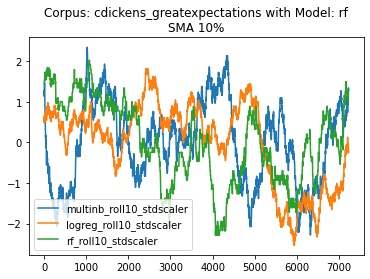

In [ ]:
# Option (b): SA Timeseries -> (SMA 10%) -> (z-Score Standardization)

# Rolling z-score: https://stackoverflow.com/questions/47164950/compute-rolling-z-score-in-pandas-dataframe

def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

# df['zscore'] = zscore(df['value'],window)

for i, acorpus in enumerate(corpora_ls):
  for j, amodel in enumerate(models_ml_ls):

    # Vectorize Corpus ----------

    best_emb_type = best_emb_dt[amodel] 

    # Select the best embedding technique on IMDB to vectorize Corpus
    if best_emb_type == 'count':
      # CountVectorizer on Corpus
      X_corpus_emb =  count_vect.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf':
      # TF-IDF (Words) on Corpus
      X_corpus_emb =  tfidf_vect.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf_ngram':
      # TF-IDF (ngrams) on Corpus
      X_corpus_emb =  tfidf_vect_ngram.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf_ngram_chars':
      # TF-IDF (chars) on Corpus
      X_corpus_emb =  tfidf_vect_ngram_chars.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'hash':
      # TF-IDF (chars) on Corpus
      X_corpus_emb =  hash_vect.transform(corpora_dt[acorpus]['sent_clean'])

    else:
      # ERROR
      print(f'ERROR: Illegal value for best embedding technique (best_emb_type): {best_emb_type}')

    # Predict Sentiments ----------
    corpus_ml_dt[acorpus][amodel] =  pd.Series(predict_cls(amodel, X_corpus_emb))

    # Standardize and create Simple Moving Average (SMA 10%)
    print(f'\n\nPlot #{i*len(models_ml_ls) + j}: {acorpus} with model {amodel}')
    win10per = int(corpus_ml_dt[acorpus].shape[0]*0.1)
    # del temp_df
    # temp_df = pd.DataFrame()
    # temp_df['zscore'] = zscore(corpus_ml_dt[acorpus][amodel],win10per)
    # corpus_ml_dt[acorpus][amodel].rolling(win10per, center=True).mean().plot();
    
    # float_array = corpus_ml_dt[acorpus][amodel].values.astype(float)
    amodel_roll10_stdscaler = f'{amodel}_roll10_stdscaler'
    corpus_ml_dt[acorpus][amodel_roll10_stdscaler] = corpus_ml_dt[acorpus][amodel].rolling(win10per, min_periods=(win10per//2), center=True).mean()
    float_array = corpus_ml_dt[acorpus][amodel_roll10_stdscaler].values.astype(float)
    mean_std_scaler.fit_transform(float_array.reshape(-1,1))
    corpus_ml_dt[acorpus][amodel_roll10_stdscaler] = mean_std_scaler.fit_transform(float_array.reshape(-1,1))
    # temp_df['zscore'].rolling(win10per, center=True).mean().plot()
    # zscore(corpus_ml_dt[acorpus][amodel],win10per).rolling(win10per, center=True).mean().plot()
    corpus_ml_dt[acorpus][amodel_roll10_stdscaler].plot() # .rolling(win10per, center=True).mean().plot()
    plt.title(f'Corpus: {acorpus} with Model: {amodel}\nSMA 10%');
    plt.legend(loc='best')  
  plt.show();

# **AutoML Solutions**

In [ ]:
automl_ls = ['flaml']

## **Read Prior Sentiments for Corpora**

In [ ]:
!ls -d */

In [ ]:
corpus_ml_dt = {}

In [ ]:
listing = glob.glob('./data_corpora_sa/models_ml_*.csv')
for i,filename in enumerate(listing):
  fileparts_ls = filename.split('/')
  datafile_str = ''.join(fileparts_ls[-1])
  corpus_str = '_'.join(datafile_str.split('_')[2:])
  corpus_str = corpus_str.split('.')[0]
  print(f'\nReading #{i}: {filename}\n   datafile.csv: {datafile_str}\n         corpus: {corpus_str}')
  corpus_ml_dt[corpus_str] = pd.read_csv(f'./data_corpora_sa/{datafile_str}', index_col=[0])

In [ ]:
corpus_ml_dt['cdickens_achristmascarol'].head()

In [ ]:
corpus_ml_dt['cdickens_achristmascarol'].head()

## **Microsoft FLAML [RESTART RUNTIME]**

* https://github.com/microsoft/FLAML/blob/main/notebook/flaml_automl.ipynb
* https://www.youtube.com/watch?v=bJfDJhe-O-c

In [ ]:
from flaml import AutoML

automl = AutoML()

In [ ]:
# Pick the best embedding based upon IMDB train/test metrics (4/5 X_train_tfidf_ngram)

X_train = X_train_tfidf_ngram
X_test = X_test_tfidf_ngram

In [ ]:
%%time

# NOTE: 1m12s (default time budget)

# Default Classification Search:  ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'lrl1']

# automl.fit(X_train, y_train, task="classification")

In [ ]:
# from flaml import AutoML
# from sklearn.datasets import load_iris

In [ ]:
# !mkdir logs_flaml

In [ ]:
%%time

# NOTE: 22m28s on 20210918 at 23:10 (IMDB)

# Customize FLAML Search

# Initialize an AutoML instance
automl = AutoML()

# Specify automl goal and constraint
automl_settings = {
    "time_budget": 600, # 900,  # in seconds
    "metric": 'accuracy',
    "task": 'classification',
    "log_file_name": "logs_flaml/flaml.log",
}

# Train with labeled input data
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

# Predict
print(automl.predict_proba(X_train))

# Export the best model
print(automl.model)

"""
[flaml.automl: 09-19 03:01:20] {1735} INFO - iteration 175, current learner lrl1
No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'.
[flaml.automl: 09-19 03:01:31] {1920} INFO -  at 908.4s,	best lrl1's error=0.5050,	best catboost's error=0.4796
[flaml.automl: 09-19 03:01:31] {2021} INFO - selected model: <catboost.core.CatBoostClassifier object at 0x7fd8fa364710>
[flaml.automl: 09-19 03:08:51] {2084} INFO - retrain catboost for 440.1s
[flaml.automl: 09-19 03:08:51] {2088} INFO - retrained model: <catboost.core.CatBoostClassifier object at 0x7fd8ee43b8d0>
[flaml.automl: 09-19 03:08:51] {1529} INFO - fit succeeded
[flaml.automl: 09-19 03:08:51] {1531} INFO - Time taken to find the best model: 852.8518950939178
[flaml.automl: 09-19 03:08:51] {1545} WARNING - Time taken to find the best model is 95% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
""";

In [ ]:
# Retrieve best config and best learner

print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

"""
Best ML leaner: catboost
Best hyperparmeter config: {'early_stopping_rounds': 13, 'learning_rate': 0.05455865754453469}
Best accuracy on validation data: 0.5204
Training duration of best run: 39.15 s
""";

In [ ]:
automl.model.estimator

In [ ]:
# compute predictions of testing dataset

y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('\nTrue labels', y_test)

# y_pred_proba = automl.predict_proba(X_test)[:,1]

# Get Metrics on Fitting IMDB
# get_metrics(clf_flaml, X_test, y_test)

In [ ]:
acc = accuracy_score(y_test, y_pred)
f1=f1_score(y_test, y_pred)
cm=confusion_matrix(y_test, y_pred)
report=classification_report(y_test,y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm,annot=True,cmap='Blues',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show();
print("\nAccuracy: ",round(acc,2))
print("\nF1 Score: ",round(f1,2))
print("\nConfusion Matrix: \n",cm)
print("\nReport:",report);

"""
budget time = 900s 

Accuracy:  0.87

F1 Score:  0.88

""";

In [ ]:
# Metric matthews_corrcoef

mcc_y_test_predict = matthews_corrcoef(y_test, y_pred)
mcc_y_test_predict

In [ ]:
corpus_ml_dt['cdickens_achristmascarol'].head()

In [ ]:
for i, acorpus in enumerate(corpora_ls):
  print(f'Corpus #{i}: {acorpus}')

In [ ]:
%%time

# NOTE:

# Option (a): SA Timeseries -> (z-Score Standardization) -> (SMA 10%)

# Rolling z-score: https://stackoverflow.com/questions/47164950/compute-rolling-z-score-in-pandas-dataframe

def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

# df['zscore'] = zscore(df['value'],window)

# For each individual corpus in our collection
for i, acorpus in enumerate(corpora_ls):

  # Apply each ML Model to compute sentiment values on each sentence
  for j, amodel in enumerate(models_ml_ls):

    # Vectorize Corpus ----------
    best_emb_type = best_emb_dt[amodel] 

    # Select the best embedding technique on IMDB to vectorize Corpus
    if best_emb_type == 'count':
      # CountVectorizer on Corpus
      X_corpus_emb =  count_vect.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf':
      # TF-IDF (Words) on Corpus
      X_corpus_emb =  tfidf_vect.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf_ngram':
      # TF-IDF (ngrams) on Corpus
      X_corpus_emb =  tfidf_vect_ngram.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf_ngram_chars':
      # TF-IDF (chars) on Corpus
      X_corpus_emb =  tfidf_vect_ngram_chars.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'hash':
      # TF-IDF (chars) on Corpus
      X_corpus_emb =  hash_vect.transform(corpora_dt[acorpus]['sent_clean'])

    else:
      # ERROR
      print(f'ERROR: Illegal value for best embedding technique (best_emb_type): {best_emb_type}')

    # Predict Sentiments ----------
    corpus_ml_dt[acorpus][amodel] =  pd.Series(predict_cls(amodel, X_corpus_emb))

    # Standardize and create Simple Moving Average (SMA 10%)
    print(f'\n\nPlot #{i*len(models_ml_ls) + j}: {acorpus} with model {amodel}')
    win10per = int(corpus_ml_dt[acorpus].shape[0]*0.1)
    # del temp_df
    # temp_df = pd.DataFrame()
    # temp_df['zscore'] = zscore(corpus_ml_dt[acorpus][amodel],win10per)
    # corpus_ml_dt[acorpus][amodel].rolling(win10per, center=True).mean().plot();
    
    float_array = corpus_ml_dt[acorpus][amodel].values.astype(float)
    amodel_stdscaler = f'{amodel}_stdscaler'
    corpus_ml_dt[acorpus][amodel_stdscaler] = mean_std_scaler.fit_transform(float_array.reshape(-1,1))
    # temp_df['zscore'].rolling(win10per, center=True).mean().plot()
    # zscore(corpus_ml_dt[acorpus][amodel],win10per).rolling(win10per, center=True).mean().plot()
    corpus_ml_dt[acorpus][amodel_stdscaler].rolling(win10per, center=True).mean().plot()
    plt.title(f'Corpus: {acorpus} with Model: {amodel}\nz-Score Standardardized SMA 10%');
    plt.legend(loc='best')  
  plt.show();

In [ ]:
"""
%%time

# NOTE: 1m08s

# Random Forests

clf_flaml = automl.predict() # XGBClassifier()
clf_flaml.fit(X_train, y_train)

# Get Metrics on Fitting IMDB
get_metrics(clf_flaml, X_test, y_test)
""";

## **HyperOpt-Sklearn**

* https://machinelearningmastery.com/hyperopt-for-automated-machine-learning-with-scikit-learn/ 

* https://github.com/hyperopt/hyperopt-sklearn

* https://github.com/hyperopt/hyperopt-sklearn/blob/master/notebooks/Demo-Iris.ipynb 

svc
svc_linear
svc_rbf
svc_poly
svc_sigmoid
liblinear_svc

knn

ada_boost
gradient_boosting

random_forest
extra_trees
decision_tree

sgd

xgboost_classification

multinomial_nb
gaussian_nb

passive_aggressive

linear_discriminant_analysis
quadratic_discriminant_analysis

one_vs_rest
one_vs_one
output_code

In [ ]:
!pip install hyperopt

In [ ]:
!pip show hyperopt

In [ ]:
!pip install git+https://github.com/hyperopt/hyperopt-sklearn

In [ ]:
!ls -d */

In [ ]:
!ls -d */


In [ ]:
%cd hyperopt-sklearn

!sudo pip install .

%cd ..

In [ ]:
!pip show hpsklearn

In [ ]:
%%time

# NOTE:

# example of hyperopt-sklearn for the sonar classification dataset
# https://machinelearningmastery.com/hyperopt-for-automated-machine-learning-with-scikit-learn/

# from pandas import read_csv
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing

from hyperopt import tpe

"""
# load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv'
dataframe = read_csv(url, header=None)

# split into input and output elements
data = dataframe.values
X, y = data[:, :-1], data[:, -1]

# minimally prepare dataset
X = X.astype('float32')
y = LabelEncoder().fit_transform(y.astype('str'))

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
""";

# define search
model = HyperoptEstimator(classifier=any_classifier('cla'), preprocessing=any_preprocessing('pre'), algo=tpe.suggest, max_evals=50, trial_timeout=30)

# perform the search
model.fit(X_train, y_train)

In [ ]:
from hpsklearn import HyperoptEstimator, svc
from sklearn import svm

# Load Data
# ...

use_hpsklearn = True

if use_hpsklearn:
    estim = HyperoptEstimator(classifier=svc('mySVC'))
else:
    estim = svm.SVC()

estim.fit(X_train, y_train)

print(estim.score(X_test, y_test))

In [ ]:
%%time

# NOTE:

# summarize performance
acc = model.score(X_test, y_test)
print("Accuracy: %.3f" % acc)

# summarize the best model
print(model.best_model())

## **AutoGluon Text**

References: 

* https://auto.gluon.ai/stable/tutorials/text_prediction/beginner.html

* https://auto.gluon.ai/tutorials/text_classification/beginner.html

* https://linuxtut.com/en/22cf80a4be80f7ad458e/

In [ ]:
!pip install gluonnlp==0.8.1

In [ ]:
!pip install autogluon

In [ ]:
# !pip install mxnet

!pip install --upgrade mxnet-cu100

In [ ]:
training_df.head()

In [ ]:
training_df.info()

In [ ]:
# Manually create train/test split from training_df DataFrame

train_per = 0.9 # 80% with large dataset 50k labeled sentiments

split_idx = int(train_per*training_df.shape[0])
train_data = training_df[:split_idx]
print(f'train_data.shape: {train_data.shape}')
test_data = training_df[split_idx:]
print(f'test_data.shape: {test_data.shape}')

In [ ]:
train_data.head()
train_data.drop(columns=['sent_no','text_raw'], axis=1, inplace=True)
train_data.rename(columns={'text_clean':'sentence', 'polarity':'label'}, inplace=True)
train_data['sentence'] = train_data['sentence'].astype('string')
train_data.head()

In [ ]:
test_data.head()
test_data.drop(columns=['sent_no','text_raw'], axis=1, inplace=True)
test_data.rename(columns={'text_clean':'sentence', 'polarity':'label'}, inplace=True)
test_data['sentence'] = test_data['sentence'].astype('string')
test_data.head()

In [ ]:
%%time

# NOTE:

from autogluon.core.utils.loaders.load_pd import load

# train_data = load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/train.parquet')
# test_data = load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/dev.parquet')

# subsample_size = 1000  # subsample data for faster demo, try setting this to larger values

# train_data = train_data.sample(n=subsample_size, random_state=0)
train_data.head(10)

In [ ]:
type(train_data)

In [ ]:
!ls -d */

In [ ]:
%%time

# NOTE: 11m01s on 20210919 at 18:00 (train_max = 60) 
#       [Iter 66/3300, Epoch 0] valid f1=8.9398e-01, 
#        mcc=7.8881e-01, roc_auc=9.5905e-01, accuracy=8.9440e-01, 
#        log_loss=2.6857e-01, time spent=57.956s, total time spent=10.11min. 
#        Find new best=True, Find new top-3=True

train_max = 60 # in seconds
from autogluon.text import TextPredictor

predictor = TextPredictor(label='label', eval_metric='acc', path='./ag_imdb')
predictor.fit(train_data, time_limit=train_max)

In [ ]:
%%time

# NOTE:

# Evaluation

test_score = predictor.evaluate(test_data)
print('Accuracy = {:.2f}%'.format(test_score * 100))

# Demo: Accuracy = 87.50%
# IMDB: 

In [ ]:
%%time

# NOTE: 1m58s

# Evaluation

test_score = predictor.evaluate(test_data, metrics=['acc', 'f1'])
print(test_score)

# Demo: {'acc': 0.875, 'f1': 0.8816503800217155}
# IMDB: 

In [ ]:
sentence1 = "it's a charming and often affecting journey."
sentence2 = "It's slow, very, very, very slow."
predictions = predictor.predict({'sentence': [sentence1, sentence2]})
print('"Sentence":', sentence1, '"Predicted Sentiment":', predictions[0])
print('"Sentence":', sentence2, '"Predicted Sentiment":', predictions[1])

"""
Demo:
"Sentence": it's a charming and often affecting journey. "Predicted Sentiment": 1
"Sentence": It's slow, very, very, very slow. "Predicted Sentiment": 0
""";

In [ ]:
corpus_ls = corpora_dt['cdickens_achristmascarol']['sent_clean'].tolist()
type(corpus_ls)
print('\n')
print(corpus_ls[0])

In [ ]:
%%time

corpus_pred = predictor.predict({'sentence':corpus_ls})


In [ ]:
corpus_ml_dt['cdickens_achristmascarol'].head()

In [ ]:
type(corpus_pred)

In [ ]:
for i in range(5):
  print(f'{corpus_pred[i]}: {corpus_ls[i]}')

In [ ]:
%%time

# NOTE:

amodel = 'autogluon'

# For each individual corpus in our collection
for i, acorpus in enumerate(corpora_ls):

  print(f'\nCorpus #{i}: {acorpus} processing...')

  # Create a list of Sentences for each Corpus
  corpus_ls = corpus_ml_dt[acorpus]['sent_clean'].tolist()

  # Predict Sentiments for each Sentence
  corpus_pred = predictor.predict({'sentence':corpus_ls})

  # Save AutoGluon Sentiment 
  corpus_ml_dt[acorpus][amodel] = pd.Series(corpus_pred)

  # Standardize and create Simple Moving Average (SMA 10%)
  print(f'\n\nPlot #{i}: {acorpus} with model {amodel}')
  win10per = int(corpus_ml_dt[acorpus].shape[0]*0.1)
  # del temp_df
  # temp_df = pd.DataFrame()
  # temp_df['zscore'] = zscore(corpus_ml_dt[acorpus][amodel],win10per)
  # corpus_ml_dt[acorpus][amodel].rolling(win10per, center=True).mean().plot();
  
  float_array = corpus_ml_dt[acorpus][amodel].values.astype(float)
  amodel_stdscaler = f'{amodel}_stdscaler'
  corpus_ml_dt[acorpus][amodel_stdscaler] = mean_std_scaler.fit_transform(float_array.reshape(-1,1))
  # temp_df['zscore'].rolling(win10per, center=True).mean().plot()
  # zscore(corpus_ml_dt[acorpus][amodel],win10per).rolling(win10per, center=True).mean().plot()
  corpus_ml_dt[acorpus][amodel_stdscaler].rolling(win10per, center=True).mean().plot()
  plt.title(f'Corpus: {acorpus} with Model: {amodel}\nz-Score Standardardized SMA 10%');
  plt.legend(loc='best')  
  plt.show();

In [ ]:
# Verify new model sentiment values appended to DataFrames

corpus_ml_dt['cdickens_achristmascarol'].head()

In [ ]:
# Save DataFrame with new model sentiment values

for i, acorpus in enumerate(corpora_ls):

  data_dir = 'data_corpora_sa'
  model_file = f'./{data_dir}/models_ml_{acorpus}.csv'
  print(f'\n\nDataFrame #{i}: [{acorpus}]\n')
  corpus_ml_dt[acorpus].head()
  
  print(f'\n    Saving contents to file: [{model_file}]\n\n')
  corpus_ml_dt[acorpus].to_csv(model_file)

## **ONYX Transformers**

In [ ]:
!pip install -qqq --upgrade torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!git clone https://github.com/patil-suraj/onnx_transformers.git

In [ ]:
!pip install -U -qqq -e ./onnx_transformers

In [ ]:
!lscpu

In [ ]:
from onnx_transformers import pipeline

In [ ]:
# Initialize a pipeline by passing the task name and 
# set onnx to True (default value is also True)

nlp = pipeline("sentiment-analysis", onnx=True)
nlp("Transformers and onnx runtime is an awesome combo!")

# [{'label': 'POSITIVE', 'score': 0.999721109867096}]  


## **Inferring Sentiment with Trained Models**

In [ ]:
corpora_dt['cdickens_achristmascarol']['sent_clean']

In [ ]:
corpus_automl_dt = {}

for acorpus in corpora_ls:
  corpus_automl_dt[acorpus] = pd.DataFrame(corpora_dt['cdickens_achristmascarol']['sent_clean'])

In [ ]:
# Create Dictionary with one DataFrame for each corpus
#   The columns of DataFrames hold model sentiment values computed for each sentence

for key, value in corpus_automl_dt.items():
  print(f'\n\nCorpus: {key}\n{value.head()}')

# corpus_automl_dt.keys()
# corpus_automl_dt.values()

In [ ]:
def predict_cls(amodel, X_corpus_emb):
  '''
  Given a ML model and an embedded corpus
  Return a pd.Series of Sentiment Values
  '''

  if amodel == 'flaml':
    # return pd.Series(clf_flaml.predict(X_corpus_emb))
    return pd.Series(automl.predict(X_corpus_emb))
  elif amodel == 'logreg':
    return pd.Series(clf_logreg.predict(X_corpus_emb))
  elif amodel == 'logreg_cv':
    return pd.Series(clf_logreg_cv.predict(X_corpus_emb))
  elif amodel == 'rf':
    return pd.Series(clf_rf.predict(X_corpus_emb))
  elif amodel == 'xgb':
    return pd.Series(clf_xgb.predict(X_corpus_emb))
  else:
    print(f'ERROR: In predict_cls() with invalid amodel argument: {amodel}')
    return -99

In [ ]:
# Reminder: (defined above) models_ml_ls = ['multinb', 'logreg', 'logreg_cv', 'rf', 'xgb']

In [ ]:
corpus_ml_dt['fbaum_thewonderfulwizardofoz'].head(10)
corpus_ml_dt['fbaum_thewonderfulwizardofoz'].shape

In [ ]:
corpus_ml_dt['cdickens_achristmascarol'].head(10)
corpus_ml_dt['cdickens_achristmascarol'].shape

In [ ]:
corpus_ml_dt['cdickens_achristmascarol'].rolling(340, center=True).mean().plot();

In [ ]:
corpus_ml_dt['cdickens_greatexpectations'].rolling(340, center=True).mean().plot();

In [ ]:
corpus_ml_dt['cdickens_achristmascarol']['logreg'].rolling(130, center=True).mean().plot()

In [ ]:
corpora_dt['fbaum_thewonderfulwizardofoz']['sent_clean']

In [ ]:
corpora_dt['cdickens_achristmascarol']['sent_clean']

In [ ]:
del best_emb_dt['xgboost']

In [ ]:
best_emb_dt['flaml'] = 'tfidf_ngram'
best_emb_dt

In [ ]:
automl_ls

In [ ]:
%%time

# NOTE:

# Option (a): SA Timeseries -> (z-Score Standardization) -> (SMA 10%)

# Rolling z-score: https://stackoverflow.com/questions/47164950/compute-rolling-z-score-in-pandas-dataframe

def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

# df['zscore'] = zscore(df['value'],window)

# For each individual corpus in our collection
for i, acorpus in enumerate(corpora_ls):

  # Apply each ML Model to compute sentiment values on each sentence
  for j, amodel in enumerate(automl_ls):

    # Vectorize Corpus ----------

    best_emb_type = best_emb_dt[amodel] 

    # Select the best embedding technique on IMDB to vectorize Corpus
    if best_emb_type == 'count':
      # CountVectorizer on Corpus
      X_corpus_emb =  count_vect.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf':
      # TF-IDF (Words) on Corpus
      X_corpus_emb =  tfidf_vect.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf_ngram':
      # TF-IDF (ngrams) on Corpus
      X_corpus_emb =  tfidf_vect_ngram.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'tfidf_ngram_chars':
      # TF-IDF (chars) on Corpus
      X_corpus_emb =  tfidf_vect_ngram_chars.transform(corpora_dt[acorpus]['sent_clean'])

    elif best_emb_type == 'hash':
      # TF-IDF (chars) on Corpus
      X_corpus_emb =  hash_vect.transform(corpora_dt[acorpus]['sent_clean'])

    else:
      # ERROR
      print(f'ERROR: Illegal value for best embedding technique (best_emb_type): {best_emb_type}')

    # Predict Sentiments ----------
    corpus_ml_dt[acorpus][amodel] =  pd.Series(predict_cls(amodel, X_corpus_emb))

    # Standardize and create Simple Moving Average (SMA 10%)
    print(f'\n\nPlot #{i*len(models_ml_ls) + j}: {acorpus} with model {amodel}')
    win10per = int(corpus_ml_dt[acorpus].shape[0]*0.1)
    # del temp_df
    # temp_df = pd.DataFrame()
    # temp_df['zscore'] = zscore(corpus_ml_dt[acorpus][amodel],win10per)
    # corpus_ml_dt[acorpus][amodel].rolling(win10per, center=True).mean().plot();
    
    float_array = corpus_ml_dt[acorpus][amodel].values.astype(float)
    amodel_stdscaler = f'{amodel}_stdscaler'
    corpus_ml_dt[acorpus][amodel_stdscaler] = mean_std_scaler.fit_transform(float_array.reshape(-1,1))
    # temp_df['zscore'].rolling(win10per, center=True).mean().plot()
    # zscore(corpus_ml_dt[acorpus][amodel],win10per).rolling(win10per, center=True).mean().plot()
    corpus_ml_dt[acorpus][amodel_stdscaler].rolling(win10per, center=True).mean().plot()
    plt.title(f'Corpus: {acorpus} with Model: {amodel}\nz-Score Standardardized SMA 10%');
    plt.legend(loc='best')  
  plt.show();

In [ ]:
corpus_ml_dt['cdickens_achristmascarol'].iloc[:20]

In [ ]:
# For each individual corpus in our collection
for i, acorpus in enumerate(corpora_ls):

  data_dir = 'data_corpora_sa'
  model_file = f'./{data_dir}/models_ml_{acorpus}.csv'
  print(f'\n\nDataFrame #{i*len(models_ml_ls) + j}: [{acorpus}]\n')
  corpus_ml_dt[acorpus].head()
  
  print(f'\n    Saving contents to file: [{model_file}]\n\n')
  corpus_ml_dt[acorpus].to_csv(model_file)

# **END OF NOTEBOOK**

In [ ]:

X_train, y_train = load_iris(return_X_y=True)
# Train with labeled input data
automl.fit(X_train=X_train, y_train=y_train,
           **automl_settings)
# Predict
print(automl.predict_proba(X_train))
# Export the best model
print(automl.model)

In [ ]:
y_train.hist()

In [ ]:
settings = {
    "time_budget": 1000,  # total running time in seconds
    "metric": 'accuracy',  # primary metrics can be chosen from: ['accuracy','roc_auc','f1','log_loss','mae','mse','r2']
    "task": 'classification',  # task type    
    "log_file_name": 'airlines_experiment.log',  # flaml log file
}

In [ ]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, **settings)

"""

[flaml.automl: 08-18 05:53:11] {1461} INFO - selected model: LGBMClassifier(colsample_bytree=0.7733707792852584,
               learning_rate=0.11190988982157068, max_bin=128,
               min_child_samples=62, n_estimators=701, num_leaves=12,
               objective='binary', reg_alpha=0.001291764523034099,
               reg_lambda=0.5058442385321611, verbose=-1)
[flaml.automl: 08-18 05:53:11] {1184} INFO - fit succeeded
[flaml.automl: 08-18 05:53:11] {1185} INFO - Time taken to find the best model: 567.884330034256


[flaml.automl: 08-18 05:31:22] {1411} INFO -  at 291.7s,	best extra_tree's error=0.2469,	best lgbm's error=0.1504
[flaml.automl: 08-18 05:31:27] {1438} INFO - retrain extra_tree for 5.0s
[flaml.automl: 08-18 05:31:27] {1253} INFO - iteration 46, current learner lrl1
No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'.
[flaml.automl: 08-18 05:31:41] {1411} INFO -  at 310.7s,	best lrl1's error=0.1454,	best lrl1's error=0.1454
[flaml.automl: 08-18 05:31:41] {1461} INFO - selected model: LogisticRegression(n_jobs=-1, penalty='l1', solver='saga')
[flaml.automl: 08-18 05:31:41] {1184} INFO - fit succeeded
[flaml.automl: 08-18 05:31:41] {1185} INFO - Time taken to find the best model: 310.6792550086975
[flaml.automl: 08-18 05:31:41] {1191} WARNING - Time taken to find the best model is 104% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.

""";

In [ ]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

"""

retrieve best config and best learner

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 701, 'num_leaves': 12, 'min_child_samples': 62, 'learning_rate': 0.11190988982157068, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 0.7733707792852584, 'reg_alpha': 0.001291764523034099, 'reg_lambda': 0.5058442385321611}
Best accuracy on validation data: 0.8516
Training duration of best run: 14.68 s

Best ML leaner: lrl1
Best hyperparmeter config: {'C': 1.0}
Best accuracy on validation data: 0.8546
Training duration of best run: 13.9 s

""";

In [ ]:
automl.model.estimator

"""

LogisticRegression(n_jobs=-1, penalty='l1', solver='saga')


""";

In [ ]:
''' compute predictions of testing dataset ''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]



In [ ]:
from sklearn.metrics import matthews_corrcoef

mcc_y_test_predict = matthews_corrcoef(y_test, y_pred)
mcc_y_test_predict

"""

0.7274299237200138

""";

## **SGD Classifier**

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
clf= SGDClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [ ]:
%%time

# NOTE: on 20210918 at 12:59 (IMDB)

clf= SGDClassifier(loss='hinge', 
                   penalty='l2', 
                   alpha=0.0001, 
                   l1_ratio=0.15, 
                   fit_intercept=True,
                   max_iter=1000, 
                   tol=0.001, 
                   shuffle=True, 
                   verbose=0, 
                   epsilon=0.1, 
                   n_jobs=None, 
                   random_state=42, 
                   learning_rate='optimal', 
                   eta0=0.0, 
                   power_t=0.5, 
                   early_stopping=False, 
                   validation_fraction=0.1, 
                   n_iter_no_change=5, 
                   class_weight=None, 
                   warm_start=False, 
                   average=False)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [ ]:
get_metrics(clf, X_test, y_test)

In [ ]:
pos_tweets = [('I love this car', 'positive'),
    ('This view is amazing', 'positive'),
    ('I feel great this morning', 'positive'),
    ('I am so excited about the concert', 'positive'),
    ('He is my best friend', 'positive')]

neg_tweets = [('I do not like this car', 'negative'),
    ('This view is horrible', 'negative'),
    ('I feel tired this morning', 'negative'),
    ('I am not looking forward to the concert', 'negative'),
    ('He is my enemy', 'negative')]

test_tweets = [
    ('feel happy this morning', 'positive'),
    ('larry is my friend', 'positive'),
    ('I do not like that man', 'negative'),
    ('house is not great', 'negative'),
    ('your song is annoying', 'negative')]


In [ ]:
dat = []
for i in pos_tweets+neg_tweets+test_tweets:
    dat.append(i)
    
X = np.array(dat).T[0]
y = np.array(dat).T[1]

In [ ]:
# TfidfVectorizer?

In [ ]:
vec = TfidfVectorizer(stop_words='english', ngram_range = (1, 1), lowercase = True)
X_vec = vec.fit_transform(X)
Xtrain = X_vec[:10]
Xtest = X_vec[10:]
ytrain = y[:10]
ytest= y[10:] 

In [ ]:
pd.DataFrame(X_vec.toarray(), columns=vec.get_feature_names())

In [ ]:
from sklearn.naive_bayes import GaussianNB # 1. choose model class

model = GaussianNB()                       # 2. instantiate model
model.fit(Xtrain.toarray(), ytrain)                  # 3. fit model to data
y_model = model.predict(Xtest.toarray())              # 4. predict on new data
y_model

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

In [ ]:
from sklearn.svm import SVC

svc=SVC(kernel='rbf', gamma=1) # 超级参数 
svc.fit(Xtrain.toarray(), ytrain)                  # 3. fit model to data
y_model=svc.predict(Xtest.toarray())
accuracy_score(ytest, y_model)

In [ ]:
y_model 

In [ ]:
y_model=svc.predict(Xtest.toarray())
y_model

In [ ]:
# Don’t be too positive, let’s try another example:

vocabulary = vec.get_feature_names()

def classify_sentiment(str_list, model, vocabulary):
    # str_list = ['a str']
    vec_pred = TfidfVectorizer(stop_words='english', ngram_range = (1, 1), lowercase = True, vocabulary = vocabulary)
    return model.predict(vec_pred.fit_transform(str_list).toarray())

classify_sentiment(['Your song is annoying','larry is horrible'], model, vocabulary)


In [ ]:
classify_sentiment(['I do not like larry', 'larry is my friend'], svc, vocabulary)


作业

- 使用另外一种sklearn的分类器来对tweet_negative2进行情感分析

- 使用https://github.com/victorneo/Twitter-Sentimental-Analysis 所提供的推特数据进行情感分析，可以使用其代码 https://github.com/victorneo/Twitter-Sentimental-Analysis/blob/master/classification.py

- Sentiment Analysis of IMDb movie review Dataset Using Sklearn https://nbviewer.jupyter.org/github/rasbt/python-machine-learning-book/blob/master/code/ch08/ch08.ipynb

## PaddlePaddle
 
<div><img src="https://github.com/chengjun/mybook/blob/main/images/paddlepaddle.png?raw=1" align="right"></div>  飞桨（PaddlePaddle）以百度多年的深度学习技术研究和业务应用为基础，集深度学习核心框架、基础模型库、端到端开发套件、工具组件和服务平台于一体，2016 年正式开源，是全面开源开放、技术领先、功能完备的产业级深度学习平台。 

http://paddlepaddle.org

https://github.com/PaddlePaddle/book/tree/develop/06.understand_sentiment

## Turicreate

https://github.com/apple/turicreate

<div><img src="https://github.com/chengjun/mybook/blob/main/images/turicreate.png?raw=1" align = "right"></div>
Turi Create simplifies the development of custom machine learning models. You don't have to be a machine learning expert to add recommendations, object detection, image classification, image similarity or activity classification to your app.


https://apple.github.io/turicreate/docs/userguide/text_classifier/

https://www.kaggle.com/prakharrathi25/updated-turicreate-sentiment-analysis

![image.png](https://github.com/chengjun/mybook/blob/main/images/end.png?raw=1)

## Creating Sentiment Classifier with Turicreate

In this notebook, I will explain how to develop sentiment analysis classifiers that are based on a bag-of-words model. 
Then, I will demonstrate how these classifiers can be utilized to solve Kaggle's "When Bag of Words Meets Bags of Popcorn" challenge.

Using <del>GraphLab</del> Turicreate it is very easy and straight foward to create a sentiment classifier based on bag-of-words model. Given a dataset stored as a CSV file, you can construct your sentiment classifier using the following code: 

In [ ]:
# toy code, do not run it

import turicreate as tc

train_data = tc.SFrame.read_csv(traindata_path,header=True, 
                                delimiter='\t',quote_char='"', 
                                column_type_hints = {'id':str, 
                                                     'sentiment' : int, 
                                                     'review':str } )
train_data['1grams features'] = tc.text_analytics.count_ngrams(
    train_data['review'],1)
train_data['2grams features'] = tc.text_analytics.count_ngrams(
    train_data['review'],2)

cls = tc.classifier.create(train_data, target='sentiment', 
                           features=['1grams features',
                                     '2grams features'])


In the rest of this notebook, we will explain this code recipe in details, by demonstrating how this recipe can used to create IMDB movie reviews sentiment classifier.

Before we begin constructing the classifiers, we need to import some Python libraries: turicreate (tc), and IPython display utilities.

In [ ]:
import turicreate as tc
from IPython.display import display
from IPython.display import Image

### IMDB movies reviews Dataset 

> Bag of Words Meets Bags of Popcorn



Throughout this notebook, I will use Kaggle's IMDB movies reviews datasets that is available to download from the following link: https://www.kaggle.com/c/word2vec-nlp-tutorial/data. I downloaded labeledTrainData.tsv and testData.tsv files, and unzipped them to the following local files.

###  DeepLearningMovies

Kaggle's competition for using Google's word2vec package for sentiment analysis

https://github.com/wendykan/DeepLearningMovies

In [ ]:
traindata_path = "/Users/datalab/bigdata/cjc/kaggle_popcorn_data/labeledTrainData.tsv"
testdata_path = "/Users/datalab/bigdata/cjc/kaggle_popcorn_data/testData.tsv"

### Loading Data

We will load the data with IMDB movie reviews to an SFrame using SFrame.read_csv function.

In [ ]:
movies_reviews_data = tc.SFrame.read_csv(traindata_path,header=True, 
                                         delimiter='\t',quote_char='"', 
                                         column_type_hints = {'id':str, 
                                                              'sentiment' : str, 
                                                              'review':str } )

By using the SFrame show function, we can visualize the data and notice that the train dataset consists of 12,500 positive and 12,500 negative, and overall 24,932 unique reviews.

In [ ]:
movies_reviews_data

### Constructing Bag-of-Words Classifier 

One of the common techniques to perform document classification (and reviews classification) is using Bag-of-Words model, in which the frequency of each word in the document is used as a feature for training a classifier. GraphLab's text analytics toolkit makes it easy to calculate the frequency of each word in each review. Namely, by using the count_ngrams function with n=1, we can calculate the frequency of each word in each review. By running the following command:

In [ ]:
movies_reviews_data['1grams features'] = tc.text_analytics.count_ngrams(movies_reviews_data ['review'],1)

By running the last command, we created a new column in movies_reviews_data SFrame object. In this column each value is a dictionary object, where each dictionary's keys are the different words which appear in the corresponding review, and the dictionary's values are the frequency of each word.
We can view the values of this new column using the following command.

In [ ]:
movies_reviews_data#[['review','1grams features']]

We are now ready to construct and evaluate the movie reviews sentiment classifier using the calculated above features. But first, to be able to perform a quick evaluation of the constructed classifier, we need to create labeled train and test datasets. We will create train and test datasets by randomly splitting the train dataset into two parts. The first part will contain 80% of the labeled train dataset and will be used as the training dataset, while the second part will contain 20% of the labeled train dataset and will be used as the testing dataset. We will create these two dataset by using the following command:  

In [ ]:
train_set, test_set = movies_reviews_data.random_split(0.8, seed=5)

We are now ready to create a classifier using the following command:

In [ ]:
model_1 = tc.classifier.create(train_set, target='sentiment', \
                               features=['1grams features'])

We can evaluate the performence of the classifier by evaluating it on the test dataset

In [ ]:
result1 = model_1.evaluate(test_set)

In order to get an easy view of the classifier's prediction result, we define and use the following function

In [ ]:
def print_statistics(result):
    print( "*" * 30)
    print( "Accuracy        : ", result["accuracy"])
    print( "Confusion Matrix: \n", result["confusion_matrix"])
print_statistics(result1)

As can be seen in the results above, in just a few relatively straight foward lines of code, we have developed a sentiment classifier that has accuracy of about ~0.88. Next, we demonstrate how we can improve the classifier accuracy even more.

### Improving The Classifier

One way to improve the movie reviews sentiment classifier is to extract more meaningful features from the reviews. One method to add additional features, which might be meaningful, is to calculate the frequency of every two consecutive words in each review. To calculate the frequency of each two consecutive words in each review, as before, we will use turicreate's count_ngrams function only this time we will set n to be equal 2 (n=2) to create new column named '2grams features'.  

In [ ]:
movies_reviews_data['2grams features'] = tc.text_analytics.count_ngrams(movies_reviews_data['review'],2)

In [ ]:
movies_reviews_data

As before, we will construct and evaluate a movie reviews sentiment classifier. However, this time we will use both the '1grams features' and the '2grams features' features

In [ ]:
train_set, test_set = movies_reviews_data.random_split(0.8, seed=5)
model_2 = tc.classifier.create(train_set, target='sentiment', features=['1grams features','2grams features'])
result2 = model_2.evaluate(test_set)

In [ ]:
print_statistics(result2)

Indeed, the new constructed classifier seems to be more accurate with an accuracy of about ~0.9.

### Unlabeled Test File

To test how well the presented method works, we will use all the 25,000 labeled IMDB movie reviews in the train dataset to construct a classifier. Afterwards, we will utilize the constructed classifier to predict sentiment for each review in the unlabeled dataset. Lastly, we will create a submission file according to Kaggle's guidelines and submit it. 

In [ ]:
traindata_path = "/Users/datalab/bigdata/cjc/kaggle_popcorn_data/labeledTrainData.tsv"
testdata_path = "/Users/datalab/bigdata/cjc/kaggle_popcorn_data/testData.tsv"
#creating classifier using all 25,000 reviews
train_data = tc.SFrame.read_csv(traindata_path,header=True, delimiter='\t',quote_char='"', 
                                column_type_hints = {'id':str, 'sentiment' : int, 'review':str } )
train_data['1grams features'] = tc.text_analytics.count_ngrams(train_data['review'],1)
train_data['2grams features'] = tc.text_analytics.count_ngrams(train_data['review'],2)

cls = tc.classifier.create(train_data, target='sentiment', features=['1grams features','2grams features'])
#creating the test dataset
test_data = tc.SFrame.read_csv(testdata_path,header=True, delimiter='\t',quote_char='"', 
                               column_type_hints = {'id':str, 'review':str } )
test_data['1grams features'] = tc.text_analytics.count_ngrams(test_data['review'],1)
test_data['2grams features'] = tc.text_analytics.count_ngrams(test_data['review'],2)

#predicting the sentiment of each review in the test dataset
test_data['sentiment'] = cls.classify(test_data)['class'].astype(int)

#saving the prediction to a CSV for submission
test_data[['id','sentiment']].save("/Users/datalab/bigdata/cjc/kaggle_popcorn_data/predictions.csv", format="csv")

We then submitted the predictions.csv file to the Kaggle challange website and scored AUC of about 0.88.

### Further Readings

Further reading materials can be found in the following links:

http://en.wikipedia.org/wiki/Bag-of-words_model

https://dato.com/products/create/docs/generated/graphlab.SFrame.html

https://dato.com/products/create/docs/graphlab.toolkits.classifier.html

https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words

Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). "Learning Word Vectors for Sentiment Analysis." The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).
